# Purpose


### 2023-04-28
FIX: the target subreddit name was incorrectly mapped in the previous table. Fixed it by pulling it with a regex from the DEEP LINK URI.

NOTE: we won't be able to use nearest distance as input because I hadn't calculated it for r/`ich_iel` (the actual target subreddit, NOT r/`de`) 

In this notebook we'll get user<>subreddit table & training data for a single campaign & run models for that campaign.

#### Changes & hypothesis to test in this iteration:
- Install & test new models (sklearn's `HistGradientBoostingClassifier`, XGBoost, LightGBM)
    - XGboost is a good OG
    - LightGBM does a good job with categorical variables
    - `HistGradientBoostingClassifier` is a LightGBM clone inside of sklearn

#### Changes to test in next iteration:

- Features: Replace ANN distance metrics with ToSubreddit percent
    - ANN distance is time & compute expensive (1st we need to get weighted embeddings, 2nd get ANN distance)
    - Can we replace with ToSubreddit 
- Features: iteration v2
    - Target subreddit
        - add percent of users L28 for top countries
    - User:
        - engagement cohort
        - frequency cohort
    - user <> subreddit (already pre-computed in feature store)
        - target sub: visit ratio N-days (14, 30)
            - how many days did a user visit the subreddit?
            - E.g., 14 days: Percent of last 14 days that user visited the subreddit
                - E.g., 1/14 = 0.0714 => 1 day in last 14 days
            - ** Need to "explode" this one in BQ because it's also encoded in same way as ToSub
        - 3 nearest subs to target sub: visit ratio N-days (14, 30)
            - same as target sub, but calculate it over 3 ANNs to target sub. Aggregate by SUM() or MEAN()
    - user <> subreddit (did these come from the PN model from ML?)
        - user_subreddit_trending_pn_clicked_l7
        - user_subreddit_trending_pn_clicked_l14
        - user_subreddit_trending_pn_received_l14
        - user_subreddit_trending_pn_received_l7
        - Days on subreddit (L7, L28) (this feature is a repeats info from visit ratio, so may not be needed)


---

**DONE (previous steps/notebooks)**
- Pull data:
    - User Time on Subreddit (save to local now, GCS in prod)
    - Get subreddit-level embeddings (save to local, GCS in prod)
- Reshape to get user-embeddings
    - For each ToSub file, get weighted embeddings for a user
        - Save user-level (weighted) embeddings to file
- Calculate ANN distance to input subreddit(s)
    - Create an index with ANNOY: per COUNTRY + subreddit
        - This way we ensure a minimum # of users per country
    - Load subreddit-embedding file
    - For each input target subreddit, get the ANN users
        - Try nearest 3 million users
    - Save raw ANN file

- Change scoring metrics suffix from `weighted` (e.g., `f1_weighted` -> `f1_macro`, `f1`)
    - Why? Because `weighted` gives too much value to the majority class (no clicks) and we care more about the minority class (click)
    - `macro` (both positive & negative) 
    - and `empty`/null (only report the positive class)
- Does stratifying on other important columns help at train/test split?
- How does scaling features improve robustness?
    - Answer: it did not, and in some cases it hurt performance


**This notebook:** <br>
(Quick version of these steps. We'll re-write when scaling up to multiple campaigns b/c the data will prob change)
- Load training data & labels for modeling (click/no click)
- Split into basic train/test fold
- Train base models on labeled data
    - Quick evaluation of model


**TODO later / out of scope**
<br> Do these steps once we have models that do well enough to actually score over 100 subreddits.
- Run inference on all users & get proba() for all users & user<>sub combination
    - Save proba raw file
- Rank users by proba
    - Compare which users our model would say likely to click, but didn't even receive the PN
- Reshape user<>subreddit proba PN for bigQuery
    - Pick top 1 million users per subreddit

- Split training file into k-fold validation or train/test
- Train base models (do it a separate notebook)
- [later/tbd] Reshape ANN table & upload to BQ table
    - Reshape ANN file for BigQuery format
    - Upload ANN file to BQ for table creation




# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import gc
import logging
from logging import info
import os
from pathlib import Path
import json

import polars as pl
import numpy as np
import pandas as pd
import plotly
import seaborn as sns

from tqdm.auto import tqdm
import dask
import mlflow

import subclu
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils import set_working_directory, get_project_subfolder
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl, 
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates


# ===
# imports specific to this notebook
from typing import Tuple, Union

from subclu.models.nn_annoy import AnnoyIndex
from subclu.utils.eda import get_venn_sets2

from matplotlib_venn import venn2_unweighted

from google.cloud import bigquery
from subclu.pn_models import get_data


client = bigquery.Client()

print_lib_versions([bigquery, np, pd, pl, plotly, mlflow, subclu])

python		v 3.7.10
===
google.cloud.bigquery	v: 2.13.1
numpy		v: 1.19.5
pandas		v: 1.2.4
polars		v: 0.17.1
plotly		v: 5.11.0
mlflow		v: 1.16.0
subclu		v: 0.6.1


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Define local path for this model outputs

In [4]:
manual_model_timestamp = datetime.utcnow().strftime('%Y-%m-%d_%H%M%S')
path_this_model = get_project_subfolder(
    f"data/models/pn_model/pn_manual_test_{manual_model_timestamp}"
)
Path.mkdir(path_this_model, parents=True, exist_ok=True)
print(path_this_model)

/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-01_050101


In [5]:
path_ann_df = Path("/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-04-19_172950")
f_ann_df = str(path_ann_df / "df_ann_distance_to_target-10533999_5.parquet")

In [6]:
!ls $path_ann_df

df_ann_distance_to_target-10533999_5.parquet
df_ann_distance_to_target-10533999_6.parquet
df_subreddit_embeddings_wide-236115_102.parquet
df_user_embedding-2023-04-19_1841-10533999_by_101.parquet


# Define key inputs
Use these throughout the process to filter/target specific subreddits, geos, & users

In [8]:
l_target_subreddits = ['ich_iel']

# We would want to add an automated way to pick these ANN subs, but look them up manually for now
l_target_ann_subreddits = ['fragreddit', 'de']

l_target_geos = ['DE']

# Load & reshape data

## Load training data from BQ

Label info:
- send, receive, click [Click is the target, but we need sends & receives so that we can select only users who received or clicked]

Selected features v0:
- TODO: num of subreddits in ToS calculation
- views, consumes, etc. in target subreddit
- User latest country
- user<>subreddit distances (currently in a local file, not in BQ)

features to add for v1:
- target subreddit percentage visits from different geos (wide version of `community_score` table)
- target subreddit primary language
- user primary language(s)

#### Features to add maybe way later(?)
`Subscription` tables expire after 90 days... (sigh)
<br>So we'll have imperfect data for training models before 2023-02
<br>Maybe we should just exclude it for historical campaigns and only add it going forward?


**NOTE / TODO(djb)**
- For this notebook I'll only train on user who RECEIVED the PN
- But in the future we might want to model whether someone will even receive the PN (saves us from wasting PNs on users not likely to be active... unless the goal is to re-activate dormant users)

In [9]:
%%time
%%bigquery df_train_raw --project data-science-prod-218515 

-- Select trainig data AND users to train PN model. v2023-05-01
DECLARE PT_FEATURES DATE DEFAULT "2022-12-01";
DECLARE PT_WINDOW_START DATE DEFAULT PT_FEATURES - 7;

WITH subreddit_per_user_count AS (
    SELECT
        tos.user_id
        , COUNT(DISTINCT subreddit_id) AS tos_sub_count
    FROM `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_tos_30_pct_20230418` AS tos
    GROUP BY 1
)
, post_consumes_agg AS (
    SELECT
        user_id
        , SUM(num_post_consumes) AS num_post_consumes
        , SUM(num_post_consumes_home) AS num_post_consumes_home
        , SUM(num_post_consumes_community) AS num_post_consumes_community
        , SUM(num_post_consumes_post_detail) AS num_post_consumes_post_detail
        , SUM(IF(app_name = 'ios', num_post_consumes, 0)) AS num_post_consumes_ios
        , SUM(IF(app_name = 'android', num_post_consumes, 0)) AS num_post_consumes_android
        , SUM(num_post_consumes_nsfw) AS num_post_consumes_nsfw
        , SAFE_DIVIDE(SUM(num_post_consumes_nsfw), SUM(num_post_consumes)) AS pct_post_consumes_nsfw
        -- , SUM(num_post_consumes_sfw) AS num_post_consumes_sfw
    FROM `data-prod-165221.video.post_consumes_30d_agg`
    WHERE DATE(pt) = PT_FEATURES
    GROUP BY 1
)
, core_train_info AS (
    SELECT
        -- Need to fill cases where user_id is missing from new selection criteria
        COALESCE(act.user_id, f.user_id) AS user_id
        , act.target_subreddit
        , COALESCE(act.send, 0) AS send
        , COALESCE(act.receive, 0) AS receive
        , COALESCE(act.click, 0) AS click

        -- , f.subreddit_id
        -- , f.subreddit_name AS view_sub_name
        , f.* EXCEPT(pt, pt_window_start, user_id, subreddit_name, subreddit_id)

    FROM (
        SELECT *
        FROM `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_20230418`
    ) AS f
        FULL OUTER JOIN `reddit-employee-datasets.david_bermejo.pn_training_data_test_20230428` AS act
            ON f.user_id = act.user_id
                AND f.subreddit_name = act.target_subreddit
    WHERE target_subreddit IS NOT NULL
)
, user_actions_t7 AS (
    SELECT
      pne.user_id,
      COUNT(receive_endpoint_timestamp) user_receives_pn_t7,
      COUNT(click_endpoint_timestamp) user_clicks_pn_t7,
      COUNT(
        CASE
          WHEN notification_type='lifecycle_post_suggestions'
            THEN click_endpoint_timestamp
          ELSE NULL
        END
    ) user_clicks_trnd_t7
    FROM `data-prod-165221.channels.push_notification_events` AS pne
    INNER JOIN core_train_info AS c
        ON pne.user_id = c.user_id
    WHERE
        DATE(pt) BETWEEN PT_WINDOW_START AND PT_FEATURES
        AND NOT REGEXP_CONTAINS(notification_type, "email")
        AND receive_endpoint_timestamp IS NOT NULL
  GROUP BY user_id
)

SELECT
    -- Need to fill cases where user_id is missing from new selection criteria
    ct.user_id
    , ct.target_subreddit
    , ct.send
    , ct.receive
    , ct.click
    , COALESCE(tos.tos_sub_count, 0) AS tos_sub_count
    , COALESCE(sv.feature_value, 0) AS screen_view_count_14d
    , COALESCE(cl.legacy_user_cohort, '_missing_') AS legacy_user_cohort
    , CASE 
        WHEN cl.legacy_user_cohort = 'new' THEN 1
        WHEN cl.legacy_user_cohort = 'resurrected' THEN 2
        WHEN cl.legacy_user_cohort = 'casual' THEN 3
        WHEN cl.legacy_user_cohort IS NULL THEN 4  -- '_missing_' or 'dead'
        WHEN cl.legacy_user_cohort = 'core' THEN 5
        ELSE 0
    END AS legacy_user_cohort_ord
    , pna.* EXCEPT(user_id)
    , co.* EXCEPT(user_id)
    , ct.* EXCEPT(user_id, target_subreddit, send, receive, click)

FROM core_train_info AS ct
    -- Get count of subs in ToS
    LEFT JOIN subreddit_per_user_count AS tos
        ON ct.user_id = tos.user_id
    -- Recent PN activity
    LEFT JOIN user_actions_t7 AS pna
        ON ct.user_id = pna.user_id
    -- Get view counts (all subreddits)
    LEFT JOIN (
        SELECT entity_id, feature_value
        FROM `data-prod-165221.user_feature_platform.screen_views_count_over_14_days_v1`
        WHERE DATE(pt) = PT_FEATURES
    ) AS sv
        ON ct.user_id = sv.entity_id
    -- USER cohort, Legacy
    LEFT JOIN (
        SELECT user_id, legacy_user_cohort
        FROM `data-prod-165221.attributes_platform.user_rolling_legacy_user_cohorts`
        WHERE DATE(pt) = PT_FEATURES
    ) AS cl
        ON ct.user_id = cl.user_id
    -- USER consumes
    LEFT JOIN post_consumes_agg AS co
        ON ct.user_id = co.user_id

WHERE ct.receive = 1
    -- TODO(djb): add all clicks & limit receives that were suppressed

-- Only order to check data, no need to spend time ordering for training
ORDER BY click DESC, tos_sub_count DESC
;

Downloading: 100%|██████████| 253583/253583 [00:01<00:00, 147089.30rows/s]

CPU times: user 601 ms, sys: 192 ms, total: 793 ms
Wall time: 26.9 s


In [10]:
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253583 entries, 0 to 253582
Data columns (total 29 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   user_id                              253583 non-null  object 
 1   target_subreddit                     253583 non-null  object 
 2   send                                 253583 non-null  int64  
 3   receive                              253583 non-null  int64  
 4   click                                253583 non-null  int64  
 5   tos_sub_count                        253583 non-null  int64  
 6   screen_view_count_14d                253583 non-null  int64  
 7   legacy_user_cohort                   253583 non-null  object 
 8   legacy_user_cohort_ord               253583 non-null  int64  
 9   user_receives_pn_t7                  247592 non-null  float64
 10  user_clicks_pn_t7                    247592 non-null  float64
 11  user_clicks_t

In [11]:
counts_describe(df_train_raw[['user_id', 'target_subreddit',  'click', 'subscribed']])

,dtype,count,unique,unique-percent,null-count,null-percent
user_id,object,"253,583","253,583",100.00%,0,0.00%
target_subreddit,object,"253,583",1,0.00%,0,0.00%
click,int64,"253,583",2,0.00%,0,0.00%
subscribed,float64,"148,950",1,0.00%,"104,633",41.26%


~Unclear where these duplicates came from, but for now we'll remove them.~

Now that we created a proper `target_subreddit` column that we joined on it + `user_id` (instead of only `user_id`), we removed duplicates in previous query!

In [12]:
(
    df_train_raw[df_train_raw.duplicated(subset='user_id', keep=False)]
    .sort_values(by=['user_id'])
)

,user_id,target_subreddit,send,receive,click,tos_sub_count,screen_view_count_14d,legacy_user_cohort,legacy_user_cohort_ord,user_receives_pn_t7,user_clicks_pn_t7,user_clicks_trnd_t7,num_post_consumes,num_post_consumes_home,num_post_consumes_community,num_post_consumes_post_detail,num_post_consumes_ios,num_post_consumes_android,num_post_consumes_nsfw,pct_post_consumes_nsfw,geo_country_code,subscribed,user_in_actual_but_missing_from_new,view_and_consume_unique_count,consume_unique_count,view_count,consume_count,consume_ios_count,consume_android_count


In [13]:
%%time

df_train_raw = df_train_raw.drop_duplicates(subset=['user_id'], keep=False)
df_train_raw.shape

CPU times: user 85.4 ms, sys: 13.3 ms, total: 98.7 ms
Wall time: 97.9 ms


(253583, 29)

In [14]:
counts_describe(df_train_raw[['user_id', 'target_subreddit', 'click', 'subscribed']])

,dtype,count,unique,unique-percent,null-count,null-percent
user_id,object,"253,583","253,583",100.00%,0,0.00%
target_subreddit,object,"253,583",1,0.00%,0,0.00%
click,int64,"253,583",2,0.00%,0,0.00%
subscribed,float64,"148,950",1,0.00%,"104,633",41.26%


In [15]:
assert len(df_train_raw) == df_train_raw['user_id'].nunique()

In [16]:
df_train_raw.head()

,user_id,target_subreddit,send,receive,click,tos_sub_count,screen_view_count_14d,legacy_user_cohort,legacy_user_cohort_ord,user_receives_pn_t7,user_clicks_pn_t7,user_clicks_trnd_t7,num_post_consumes,num_post_consumes_home,num_post_consumes_community,num_post_consumes_post_detail,num_post_consumes_ios,num_post_consumes_android,num_post_consumes_nsfw,pct_post_consumes_nsfw,geo_country_code,subscribed,user_in_actual_but_missing_from_new,view_and_consume_unique_count,consume_unique_count,view_count,consume_count,consume_ios_count,consume_android_count
0,t2_9zijedm0,ich_iel,1,1,1,1013,21,core,5,58.0,0.0,0.0,29743.0,2007.0,11541.0,0.0,0.0,29743.0,19575.0,0.658138,DE,0.0,0.0,64.0,64.0,0.0,160.0,0.0,160.0
1,t2_is69c8yu,ich_iel,1,1,1,954,21,core,5,52.0,32.0,27.0,21346.0,4375.0,3640.0,0.0,0.0,21346.0,17080.0,0.800150,DE,0.0,0.0,6.0,6.0,4.0,28.0,0.0,28.0
2,t2_md0rajcx,ich_iel,1,1,1,918,21,core,5,156.0,24.0,0.0,32850.0,18765.0,3873.0,0.0,0.0,32850.0,29623.0,0.901766,DE,0.0,0.0,8.0,8.0,0.0,16.0,0.0,16.0
3,t2_tahcrp1q,ich_iel,1,1,1,829,21,core,5,1.0,0.0,0.0,15246.0,2466.0,620.0,0.0,0.0,15246.0,13003.0,0.852879,DE,0.0,0.0,37.0,37.0,1.0,46.0,0.0,46.0
4,t2_hqb68gin,ich_iel,1,1,1,779,21,core,5,105.0,23.0,6.0,23333.0,3805.0,7065.0,0.0,0.0,23333.0,18981.0,0.813483,DE,0.0,0.0,6.0,6.0,2.0,26.0,0.0,26.0


## Append user<>subreddit distances 

update 2023-04-29: we don't have user<>subreddit distances for `ich_iel`, so we can't append distances.

In [17]:
# %%time

# df_ann = pl.read_parquet(
#     f_ann_df,
#     columns=['subreddit_target', 'user_id', 'cosine_similarity'],
# )
# df_ann.shape

In [18]:
# (
#     df_ann
#     .sample(n=int(1e6))
#     [['cosine_similarity']]
#     .describe()
# )

In [19]:
# %%time

# df_train = (
#     df_train_raw
#     # .drop(['subreddit_id', 'view_sub_name', ], axis=1)
#     [df_train_raw['receive'] == 1]
#     .merge(
#         df_ann.to_pandas(),
#         how='left',
#         on=['user_id', 'subreddit_target'],
#     ) 
# )

# df_train.shape

In [20]:
df_train = (
    df_train_raw.copy()
)
df_train.shape

(253583, 29)

# Some EDA

In [21]:
counts_describe(df_train)

,dtype,count,unique,unique-percent,null-count,null-percent
user_id,object,"253,583","253,583",100.00%,0,0.00%
target_subreddit,object,"253,583",1,0.00%,0,0.00%
send,int64,"253,583",1,0.00%,0,0.00%
receive,int64,"253,583",1,0.00%,0,0.00%
click,int64,"253,583",2,0.00%,0,0.00%
tos_sub_count,int64,"253,583",816,0.32%,0,0.00%
screen_view_count_14d,int64,"253,583",21,0.01%,0,0.00%
legacy_user_cohort,object,"253,583",5,0.00%,0,0.00%
legacy_user_cohort_ord,int64,"253,583",5,0.00%,0,0.00%
user_receives_pn_t7,float64,"247,592",903,0.36%,"5,991",2.36%


### All users in original campaign are in new data selection

However, this is only because I forced them into the new selection. It's possible they had views over 1 month ago OR no views at all (if the selection was based on subscription).

In [22]:
value_counts_and_pcts(
    df_train['user_in_actual_but_missing_from_new'].fillna(-1),
    sort_index=True,
    top_n=None,
)

,user_in_actual_but_missing_from_new-count,user_in_actual_but_missing_from_new-percent,user_in_actual_but_missing_from_new-pct_cumulative_sum
0.0,"148,950",58.7%,58.7%
-1.0,"104,633",41.3%,100.0%


### Click (CTR)
Since we're looking only at user that RECEIVED the PN, this CTR should be the same as the one computed in the overall dashboard

In [23]:
value_counts_and_pcts(
    df_train,
    ['click'],
    sort_index=True,
    top_n=None,
    pct_digits=3,
)

,count,percent,cumulative_percent
click,,,
1,"13,226",5.216%,5.216%
0,"240,357",94.784%,100.000%


### Clicks by Geo

In [24]:
df_geo_receive_counts = (
    df_train
    .groupby(['geo_country_code'], as_index=False)
    .agg(
        **{'receive_count': ('receive', 'count')}
    )
)

df_geos_over_200 = (
    df_geo_receive_counts
    [df_geo_receive_counts['receive_count'] >= 200]  
)
display(df_geos_over_200)

df_click_by_geo = value_counts_and_pcts(
    df_train,
    ['geo_country_code', 'click'],
    sort_index=True,
    sort_index_ascending=True,
    reset_index=True,
    top_n=None,
    return_df=True
)


style_df_numeric(
    df_click_by_geo
    [(
        (df_click_by_geo['geo_country_code'].isin(df_geos_over_200['geo_country_code'])) |
        (df_click_by_geo['geo_country_code'] == 'null')
    )]
    .drop('cumulative_percent', axis=1)
    .set_index(['geo_country_code', 'click'])
    ,
    l_bar_simple=['count', 'percent'],
)


,geo_country_code,receive_count
4,AT,625
20,CH,483
31,DE,144027
42,GB,334
90,NL,455
124,US,499


### Clicks - cohorts

In [25]:
l_imporant_cat_cols = [
    'legacy_user_cohort',
    'legacy_user_cohort_ord',
    
]

for c_ in l_imporant_cat_cols:
    print(f"\n== {c_} ==")
    display(
        value_counts_and_pcts(
            (
                df_train
                # we're now doing the FILLNA in SQL, so we shouldn't need to fill in python
                # .assign(legacy_user_cohort=df_train['legacy_user_cohort'].fillna('_missing_pd_'))
            ),
            [c_, 'click'],
            sort_index=True,
            top_n=None,
        )
    )
    display(
        value_counts_and_pcts(
            (
                df_train
                # we're now doing the FILLNA in SQL, so we shouldn't need to fill in python
                # .assign(legacy_user_cohort=df_train['legacy_user_cohort'].fillna('_missing_pd_'))
                [df_train['click'] == 1]
            ),
            [c_, 'click'],
            sort_index=True,
            top_n=None,
        )
    )


== legacy_user_cohort ==


,,count,percent,cumulative_percent
legacy_user_cohort,click,,,
resurrected,1,69,0.5%,0.5%
new,1,17,0.1%,0.7%
core,1,"11,767",89.0%,89.6%
casual,1,244,1.8%,91.5%
_missing_,1,"1,129",8.5%,100.0%



== legacy_user_cohort_ord ==


,,count,percent,cumulative_percent
legacy_user_cohort_ord,click,,,
5,1,"11,767",89.0%,89.0%
4,1,"1,129",8.5%,97.5%
3,1,244,1.8%,99.3%
2,1,69,0.5%,99.9%
1,1,17,0.1%,100.0%


### Clicks - other cuts

In [26]:
q_bins = 5

l_important_num_cols = [
    'user_clicks_pn_t7',
    'user_clicks_trnd_t7',
    'user_receives_pn_t7',
    'screen_view_count_14d',
    'num_post_consumes_home',
    # 'cosine_similarity',
    'pct_post_consumes_nsfw',
    'num_post_consumes',
    'tos_sub_count',
    'consume_ios_count',
    'consume_android_count',
    'view_count',
]
l_cols_to_bin_ = l_important_num_cols
# [
#     'tos_sub_count', 'screen_view_count_14d',
#     'user_receives_pn_t7', 'user_clicks_pn_t7', 'user_clicks_trnd_t7',
    
#     'num_post_consumes', 'num_post_consumes_community',
#     'pct_post_consumes_nsfw',
    
#     'view_and_consume_unique_count',
#     'cosine_similarity'
# ]
pctiles_ = [0.25, 0.333, 0.5, 0.6667, 0.75]
for c_to_bin_ in l_cols_to_bin_:
    c_new_ = f"{c_to_bin_}_bin"
    print(f"\n== {c_to_bin_} ==")
    fill_na_val = -2
    null_count_ = df_train[c_to_bin_].isnull().sum()
    display(style_df_numeric(df_train[c_to_bin_].describe(percentiles=pctiles_).to_frame().T))
    
    if null_count_ > 1:
        # min_val_ = min([fill_na_val, df_train[c_to_bin_].min()])
        display(style_df_numeric(df_train[c_to_bin_].fillna(fill_na_val).describe(percentiles=pctiles_).to_frame().T))
    else:
        # min_val_ = df_train[c_to_bin_].min()
        pass
    

    # Try to make better bins... ?
#     max_val_ = df_train[c_to_bin_].max()
        
#     if min_val_ < 0:
#         bins_ = 
#     else:
#         bins_ = 
    
    display(
        value_counts_and_pcts(
            (
                df_train
                .assign(
                    **{
                        c_new_: pd.qcut(
                            df_train[c_to_bin_].fillna(fill_na_val),
                            q=q_bins,
                            duplicates='drop',
                        )
                    }
                )
                [df_train['click'] == 1]
            ),
            [c_new_, 'click'],
            sort_index=True,
            top_n=None,
            pct_digits=3,
        )
    )



== user_clicks_pn_t7 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
user_clicks_pn_t7,"247,592",3.59,11.61,0.00,0.00,0.00,0.00,1.00,3.00,"2,008.00"


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
user_clicks_pn_t7,"253,583",3.46,11.51,-2.00,0.00,0.00,0.00,1.00,3.00,"2,008.00"


,,count,percent,cumulative_percent
user_clicks_pn_t7_bin,click,,,
"(4.0, 2008.0]",1,"9,087",68.706%,68.706%
"(1.0, 4.0]",1,"1,675",12.664%,81.370%
"(0.0, 1.0]",1,883,6.676%,88.046%
"(-2.001, 0.0]",1,"1,581",11.954%,100.000%



== user_clicks_trnd_t7 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
user_clicks_trnd_t7,"247,592",2.34,5.03,0.00,0.00,0.00,0.00,1.00,2.00,53.00


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
user_clicks_trnd_t7,"253,583",2.24,5.01,-2.00,0.00,0.00,0.00,1.00,2.00,53.00


,,count,percent,cumulative_percent
user_clicks_trnd_t7_bin,click,,,
"(3.0, 53.0]",1,"8,084",61.122%,61.122%
"(0.0, 3.0]",1,"1,571",11.878%,73.000%
"(-2.001, 0.0]",1,"3,571",27.000%,100.000%



== user_receives_pn_t7 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
user_receives_pn_t7,"247,592",46.76,74.30,1.00,31.00,32.00,33.00,39.00,56.00,"9,137.00"


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
user_receives_pn_t7,"253,583",45.61,73.79,-2.00,31.00,32.00,33.00,38.00,54.00,"9,137.00"


,,count,percent,cumulative_percent
user_receives_pn_t7_bin,click,,,
"(64.0, 9137.0]",1,"3,649",27.590%,27.590%
"(34.0, 64.0]",1,"2,993",22.630%,50.219%
"(32.0, 34.0]",1,"1,387",10.487%,60.706%
"(30.0, 32.0]",1,"1,984",15.001%,75.707%
"(-2.001, 30.0]",1,"3,213",24.293%,100.000%



== screen_view_count_14d ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
screen_view_count_14d,"253,583",14.02,7.70,0.00,7.00,11.00,18.00,21.00,21.00,21.00


,,count,percent,cumulative_percent
screen_view_count_14d_bin,click,,,
"(20.0, 21.0]",1,"8,495",64.230%,64.230%
"(14.0, 20.0]",1,"3,249",24.565%,88.795%
"(5.0, 14.0]",1,"1,173",8.869%,97.664%
"(-0.001, 5.0]",1,309,2.336%,100.000%



== num_post_consumes_home ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
num_post_consumes_home,"247,441","3,338.75","5,498.50",0.00,40.00,126.00,772.00,"2,762.00","4,496.00","120,607.00"


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
num_post_consumes_home,"253,583","3,257.83","5,455.73",-2.00,30.00,102.00,686.00,"2,618.00","4,345.50","120,607.00"


,,count,percent,cumulative_percent
num_post_consumes_home_bin,click,,,
"(5722.6, 120607.0]",1,"4,101",31.007%,31.007%
"(1632.0, 5722.6]",1,"3,660",27.673%,58.680%
"(234.0, 1632.0]",1,"2,935",22.191%,80.871%
"(12.0, 234.0]",1,"1,737",13.133%,94.004%
"(-2.001, 12.0]",1,793,5.996%,100.000%



== pct_post_consumes_nsfw ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
pct_post_consumes_nsfw,"235,442",0.26,0.31,0.00,0.02,0.04,0.08,0.25,0.46,1.00


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
pct_post_consumes_nsfw,"253,583",0.09,0.66,-2.00,0.02,0.03,0.07,0.20,0.40,1.00


,,count,percent,cumulative_percent
pct_post_consumes_nsfw_bin,click,,,
"(0.561, 1.0]",1,"1,101",8.325%,8.325%
"(0.123, 0.561]",1,"2,984",22.562%,30.886%
"(0.0406, 0.123]",1,"3,711",28.058%,58.945%
"(0.00651, 0.0406]",1,"3,895",29.450%,88.394%
"(-2.001, 0.00651]",1,"1,535",11.606%,100.000%



== num_post_consumes ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
num_post_consumes,"247,441","5,607.44","7,790.85",0.00,317.00,730.00,"2,423.00","5,627.25","8,026.00","159,591.00"


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
num_post_consumes,"253,583","5,471.58","7,744.09",-2.00,252.00,631.00,"2,251.00","5,415.00","7,819.00","159,591.00"


,,count,percent,cumulative_percent
num_post_consumes_bin,click,,,
"(9695.0, 159591.0]",1,"3,892",29.427%,29.427%
"(3932.0, 9695.0]",1,"3,490",26.387%,55.814%
"(1130.0, 3932.0]",1,"2,882",21.790%,77.605%
"(123.0, 1130.0]",1,"2,026",15.318%,92.923%
"(-2.001, 123.0]",1,936,7.077%,100.000%



== tos_sub_count ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
tos_sub_count,"253,583",67.63,81.36,0.00,10.00,19.00,41.00,73.00,96.00,"1,469.00"


,,count,percent,cumulative_percent
tos_sub_count_bin,click,,,
"(114.0, 1469.0]",1,"3,283",24.822%,24.822%
"(58.0, 114.0]",1,"3,404",25.737%,50.560%
"(27.0, 58.0]",1,"3,193",24.142%,74.701%
"(7.0, 27.0]",1,"2,395",18.108%,92.810%
"(-0.001, 7.0]",1,951,7.190%,100.000%



== consume_ios_count ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
consume_ios_count,"148,950",59.62,321.62,0.00,0.00,0.00,0.00,0.00,0.00,"18,716.00"


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
consume_ios_count,"253,583",34.20,248.35,-2.00,-2.00,-2.00,0.00,0.00,0.00,"18,716.00"


,,count,percent,cumulative_percent
consume_ios_count_bin,click,,,
"(0.0, 18716.0]",1,"1,668",12.612%,12.612%
"(-2.001, 0.0]",1,"11,558",87.388%,100.000%



== consume_android_count ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
consume_android_count,"148,950",232.49,599.50,0.00,1.00,3.00,13.00,62.00,152.00,"13,410.00"


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
consume_android_count,"253,583",135.74,473.74,-2.00,-2.00,-2.00,0.00,8.00,26.00,"13,410.00"


,,count,percent,cumulative_percent
consume_android_count_bin,click,,,
"(58.0, 13410.0]",1,"4,277",32.338%,32.338%
"(2.0, 58.0]",1,"2,864",21.654%,53.992%
"(-2.001, 2.0]",1,"6,085",46.008%,100.000%



== view_count ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
view_count,"148,950",46.53,134.23,0.00,0.00,0.00,2.00,12.00,28.00,"6,914.00"


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
view_count,"253,583",26.51,105.61,-2.00,-2.00,-2.00,0.00,2.00,5.00,"6,914.00"


,,count,percent,cumulative_percent
view_count_bin,click,,,
"(12.0, 6914.0]",1,"4,476",33.842%,33.842%
"(0.0, 12.0]",1,"2,667",20.165%,54.007%
"(-2.001, 0.0]",1,"6,083",45.993%,100.000%


### Subscribed

These all appear "not subscribed" because the retention time is 90 days for this table, so we don't know... sigh

In [27]:
value_counts_and_pcts(
    df_train['subscribed'].fillna(-1),
    sort_index=True,
    top_n=None,
)

,subscribed-count,subscribed-percent,subscribed-pct_cumulative_sum
0.0,"148,950",58.7%,58.7%
-1.0,"104,633",41.3%,100.0%


# Make new columns for stratification

There is too broad a difference for some key columns. If we split train/test randomly, it's possible that we won't get a similar enough distribution in the train & test splits.

In [29]:
l_strat_cat_cols = ['legacy_user_cohort_ord']

In [30]:
remove_new_bin_cols = False
l_strat_bin_cols = list()
fill_na_val_ = -1
pctiles_ = [0.25, 0.333, 0.5, 0.6667, 0.75, 0.8, 0.85]

d_cols_stratify_bins = {
    'user_clicks_pn_t7': [
        -np.inf, fill_na_val_,
        0,
        # 1,
        df_train['user_clicks_pn_t7'].quantile(q=0.75),
        np.inf
    ],
    'num_post_consumes_home': [  # .35 & .75 were too fine grained
        -np.inf, fill_na_val_,
        0,
        # df_train['num_post_consumes_home'].quantile(q=0.35),
        df_train['num_post_consumes_home'].quantile(q=0.55),
        np.inf
    ],
    
    # NSFW % is not as influential and results in too many small groups for stratification
#     'pct_post_consumes_nsfw': [  # .35 & .75 were too fine grained (couldn't stratify b/c too few members in a group)
#         -np.inf, fill_na_val_,
#         0,
#         df_train['pct_post_consumes_nsfw'].quantile(q=0.51),
#         np.inf
#     ],
    
    # Exclude these b/c they duplicate some data from other cols & stratification groups become too small
    # 'user_receives_pn_t7': [
    #     -np.inf, fill_na_val_,
    #     0,
    #     1,
    #     df_train['user_receives_pn_t7'].quantile(q=0.75),
    #     np.inf
    # ],
    # 'screen_view_count_14d': [
    #     -np.inf, fill_na_val_,
    #     0,
    #     df_train['screen_view_count_14d'].quantile(q=0.25),
    #     df_train['screen_view_count_14d'].quantile(q=0.50),
    #     np.inf
    # ],
}

for c_to_bin_, bins_ in d_cols_stratify_bins.items():
    c_new_ = f"{c_to_bin_}_bin"
    print(f"\n== {c_to_bin_} ==")
    l_strat_bin_cols.append(c_new_)
    null_count_ = df_train[c_to_bin_].isnull().sum()
    display(style_df_numeric(df_train[c_to_bin_].describe(percentiles=pctiles_).to_frame().T))
    
    if null_count_ > 1:
        # min_val_ = min([fill_na_val, df_train[c_to_bin_].min()])
        display(style_df_numeric(df_train[c_to_bin_].fillna(fill_na_val_).describe(percentiles=pctiles_).to_frame().T))
    else:
        # min_val_ = df_train[c_to_bin_].min()
        pass
    
    if len(bins_) > 0:
        # If we want to save them: convert to string and then to category 
        #  Because arrow throws errors when trying to save tuple values
        df_train[c_new_] = pd.cut(
            df_train[c_to_bin_].fillna(fill_na_val_),
            bins=bins_,
        )  # .astype(str).astype('category')
        display(
            value_counts_and_pcts(
                df_train,
                [c_new_],
                sort_index=True,
                top_n=None,
                pct_digits=3,
            ).set_caption(f"Total Distribution")
        )
        display(
            value_counts_and_pcts(
                df_train[df_train['click'] == 1],
                [c_new_, 'click'],
                sort_index=True,
                top_n=None,
                pct_digits=3,
            ).set_caption(f"Distribution of Clicks")
        )
        if remove_new_bin_cols:
            df_train = df_train.drop(c_new_, axis=1)

l_strat_bin_cols


== user_clicks_pn_t7 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,80%,85%,max
user_clicks_pn_t7,"247,592",3.59,11.61,0.00,0.00,0.00,0.00,1.00,3.00,5.00,7.00,"2,008.00"


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,80%,85%,max
user_clicks_pn_t7,"253,583",3.49,11.50,-1.00,0.00,0.00,0.00,1.00,3.00,4.00,7.00,"2,008.00"


,count,percent,cumulative_percent
user_clicks_pn_t7_bin,,,
"(3.0, inf]","57,139",22.533%,22.533%
"(0.0, 3.0]","46,095",18.177%,40.710%
"(-1.0, 0.0]","144,358",56.927%,97.637%
"(-inf, -1.0]","5,991",2.363%,100.000%


,,count,percent,cumulative_percent
user_clicks_pn_t7_bin,click,,,
"(3.0, inf]",1,"9,615",72.698%,72.698%
"(0.0, 3.0]",1,"2,030",15.349%,88.046%
"(-1.0, 0.0]",1,"1,098",8.302%,96.348%
"(-inf, -1.0]",1,483,3.652%,100.000%



== num_post_consumes_home ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,80%,85%,max
num_post_consumes_home,"247,441","3,338.75","5,498.50",0.00,40.00,126.00,772.00,"2,762.00","4,496.00","5,876.00","7,658.00","120,607.00"


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,80%,85%,max
num_post_consumes_home,"253,583","3,257.85","5,455.72",-1.00,30.00,102.00,686.00,"2,618.00","4,345.50","5,722.60","7,505.00","120,607.00"


,count,percent,cumulative_percent
num_post_consumes_home_bin,,,
"(1188.0, inf]","111,336",43.905%,43.905%
"(0.0, 1188.0]","112,265",44.272%,88.177%
"(-1.0, 0.0]","23,840",9.401%,97.578%
"(-inf, -1.0]","6,142",2.422%,100.000%


,,count,percent,cumulative_percent
num_post_consumes_home_bin,click,,,
"(1188.0, inf]",1,"8,425",63.700%,63.700%
"(0.0, 1188.0]",1,"4,463",33.744%,97.444%
"(-1.0, 0.0]",1,328,2.480%,99.924%
"(-inf, -1.0]",1,10,0.076%,100.000%


['user_clicks_pn_t7_bin', 'num_post_consumes_home_bin']

In [31]:
def create_stratify_col(
    df: pd.DataFrame,
    cols: list,
    strat_col: str = 'stratify_col',
    small_group_val: str = 'other',
) -> pd.Series:
    """Create a concatenated categorical column by combining the input columns
    This helps us replace categories with 1 item with a string so that we avoid errors
    of having only 1 item in a group
    """
    info(f"Get counts of stratified groups...")
    df_stratify_val_counts = value_counts_and_pcts(
        df,
        cols,
        top_n=None,
        return_df=True,
        reset_index=True
    )
    df_stratify_val_counts[strat_col] = (
        df_stratify_val_counts[cols[0]].astype(str)
        .str.cat(
            df_stratify_val_counts[cols[1:]].astype(str), sep="_"
        )
    ).astype('category')

    s_cats_to_group = (
        df_stratify_val_counts[df_stratify_val_counts['count'] <= 1]
        [strat_col]
    )
    info(f"{len(s_cats_to_group):04,.0f} <- Stratify Groups to Roll Up")

    info(f"Create stratified column with raw values")
    s_out = (
        df[cols[0]].astype(str)
        .str.cat(
            df[cols[1:]].astype(str), sep="_"
        )
    )
    s_out.name = strat_col

    # Change to category at the end, AFTER we append the 'other' roll up
    info(f"Replace values of orphan groups")
    s_out = pd.Series(
        np.where(
            s_out.isin(s_cats_to_group),
            small_group_val,
            s_out
        )
    ).astype('category')
    return s_out

In [32]:
%%time
col_stratify_ = 'stratify_col'
df_train[col_stratify_] = create_stratify_col(
    df=df_train,
    cols=['click'] + l_strat_cat_cols + l_strat_bin_cols,
    small_group_val='other',
)

05:03:15 | INFO | "Get counts of stratified groups..."
05:03:15 | INFO | "0,004 <- Stratify Groups to Roll Up"
05:03:15 | INFO | "Create stratified column with raw values"
05:03:15 | INFO | "Replace values of orphan groups"


CPU times: user 621 ms, sys: 82.5 ms, total: 704 ms
Wall time: 700 ms


In [33]:
counts_describe(df_train[[col_stratify_]])

,dtype,count,unique,unique-percent,null-count,null-percent
stratify_col,category,"253,583",106,0.04%,0,0.00%


In [34]:
# value_counts_and_pcts(
#     df_train['stratify_col'],
#     top_n=None,
# )

# Save train data so it's easier to jump straight into modeling
This way we can re-use the same train & test data & compare models on other runs

NOTE: for some reason the binned columns create errors when saving to parquet. If you want to save them, conver to string first and then to category. For now I'm dropping them.

In [35]:
path_this_model

PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-01_050101')

In [36]:
# %%time

# r_, c_ = df_train.drop(l_strat_bin_cols, axis=1).shape
# df_train.drop(l_strat_bin_cols, axis=1).to_parquet(
#     path_this_model / f"df_train-{r_}_{c_}.parquet"
# )
# del r_, c_

In [37]:
!ls $path_this_model

In [38]:
!du -Lsh $path_this_model/* | sort -hr 

du: cannot access '/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-01_050101/*': No such file or directory


# Split into train data & run CV folds

In [48]:
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import RobustScaler, StandardScaler  #, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier  # need to update sklearn to get LGBM-like model

from xgboost import XGBClassifier

In [41]:
%%time

# Stop using categorical columns, instead do the numeric processing in SQL to make sure
#  that the same ordinal or numeric encoding is applied upfront and on all train/test & inference values


# ordinal & boolean columns should NOT be re-scaled
l_train_cols_num_no_scale = [
    'legacy_user_cohort_ord',
]

# These numeric columns are candidates to be rescaled under some pipelines
l_train_cols_num = [
    # user-only columns
    'tos_sub_count',
    'user_receives_pn_t7',
    'user_clicks_pn_t7',
    'user_clicks_trnd_t7',
    # 'subscribed',  # Subscribed data doesn't exist for dates older than 90 days ://
    
    'screen_view_count_14d',
    'num_post_consumes',
    'num_post_consumes_home',
    'num_post_consumes_community',
    'num_post_consumes_post_detail',
    'num_post_consumes_ios',
    'num_post_consumes_android',
    'num_post_consumes_nsfw',
    'pct_post_consumes_nsfw',
    
    # user<> subreddit cols
    'view_and_consume_unique_count',
    'consume_unique_count',
    'view_count',
    'consume_count',
    'consume_ios_count',
    'consume_android_count',
    # 'cosine_similarity'  # similarity/distance excluded b/c we haven't calculated it for this sub
]
# For some features we want to flag nulls as negative to distinguish data missing
#  instead of filling as zeros
l_col_fill_neg = [
    'tos_sub_count',
    'user_receives_pn_t7',
    'user_clicks_pn_t7',
    'user_clicks_trnd_t7',
    
    'screen_view_count_14d',
    'num_post_consumes',
    'num_post_consumes_home',
    'num_post_consumes_community',
    'num_post_consumes_post_detail',
    'num_post_consumes_ios',
    'num_post_consumes_android',
    'num_post_consumes_nsfw',
    'pct_post_consumes_nsfw',
]
d_fillna_ = {c: -1 for c in l_col_fill_neg}
for c_ in l_train_cols_num:
    if c_ not in l_col_fill_neg:
        d_fillna_[c_] = 0


y = df_train['click']

X = (
    # simple strategy for nulls
    # use column transformer to handle category cols as part of pipeline
    df_train[l_train_cols_num_no_scale + l_train_cols_num].fillna(d_fillna_).copy()
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df_train[col_stratify_],
)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(202866, 20)
(202866,)
(50717, 20)
(50717,)
CPU times: user 288 ms, sys: 38.8 ms, total: 326 ms
Wall time: 325 ms


In [42]:
# xgboost needs label encoder (numeric) instead of strings
# https://stackoverflow.com/questions/71996617/invalid-classes-inferred-from-unique-values-of-y-expected-0-1-2-3-4-5-got

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)

In [43]:
value_counts_and_pcts(y_train)

,click-count,click-percent,click-pct_cumulative_sum
0,"192,284",94.8%,94.8%
1,"10,582",5.2%,100.0%


In [44]:
value_counts_and_pcts(y_test)

,click-count,click-percent,click-pct_cumulative_sum
0,"48,073",94.8%,94.8%
1,"2,644",5.2%,100.0%


In [45]:
# no longer needed because we encode as ordinal in SQL
# X_train['legacy_user_cohort'] = X_train['legacy_user_cohort'].astype('category')

In [46]:
counts_describe(X_train)

,dtype,count,unique,unique-percent,null-count,null-percent
legacy_user_cohort_ord,int64,"202,866",5,0.00%,0,0.00%
tos_sub_count,int64,"202,866",783,0.39%,0,0.00%
user_receives_pn_t7,float64,"202,866",814,0.40%,0,0.00%
user_clicks_pn_t7,float64,"202,866",224,0.11%,0,0.00%
user_clicks_trnd_t7,float64,"202,866",52,0.03%,0,0.00%
screen_view_count_14d,int64,"202,866",21,0.01%,0,0.00%
num_post_consumes,float64,"202,866","27,614",13.61%,0,0.00%
num_post_consumes_home,float64,"202,866","21,137",10.42%,0,0.00%
num_post_consumes_community,float64,"202,866","10,034",4.95%,0,0.00%
num_post_consumes_post_detail,float64,"202,866",496,0.24%,0,0.00%


In [69]:
# create dictionary where we'll append trained models to compare
d_search_fit = dict()

In [70]:
%%time
n_cv_splits = 4
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=True, random_state=42)

# set slices of train to test pipelines before running on whole data
n_train_sample_ = None
X_train_grid_ = X_train[:n_train_sample_]  # X_train[:n_train_sample_]
y_train_grid_ = y_train[:n_train_sample_]  # y_train[:n_train_sample_]

info(f"{X_train_grid_.shape} X_train.shape")
info(f"{y_train_grid_.shape} y_train.shape")

# for XGBoost, imbalanced data we can improve by passing this param (to give more weight to positive examples)
scale_pos_weight_ = float(np.sum(y_train_grid_ == 0) / np.sum(y_train_grid_ == 1))


preprocessor_ = ColumnTransformer(
    transformers=[
        # deprecate ordinalEncoder because it doesn't have .get_feature_names_out() which makes it a pain to
        #  use when interpreting the models. Instead encode these columns in SQL
        # ('ordinal', OrdinalEncoder(categories=[l_ord_enc_legacy_user_cohort]), l_train_cols_cat),
        ('scale', StandardScaler(), l_train_cols_num),
    ],
    remainder='passthrough',
)
d_models_and_params = {
    # logit takes a LOOONG time & was worse than random forest
#     'logit': {
#         'pipe': Pipeline(
#             [
#                 ('preprocess', preprocessor_),
#                 ('clf', LogisticRegression(max_iter=1000)),
#             ]
#         ),       
#         'params': {
#             'clf__C': [.1, 100],  # [.1, 1, 100]
#             # 'clf__penalty': ['l2']
#         }
#     },
    
    'rf_pre': {
        # use class_weight='balanced' to give more weight to minority class
        'pipe': Pipeline(
            [
                ('preprocess', preprocessor_),
                ('clf', RandomForestClassifier(
                    n_jobs=-1, random_state=42, class_weight='balanced'
                )),
            ]
        ),
        'params': {
            'preprocess__scale': [RobustScaler(), StandardScaler()],
            'clf__n_estimators': [800],
            'clf__criterion': ['gini',],  # ['gini', 'log_loss', 'entropy']
            'clf__max_depth': [30, 20],  # 50 too big. small (shallow) => regularize model
            'clf__min_samples_leaf': [2],  # 2 or 3. bigger => add more regularization
        }
    },
    'rf': {
        # use class_weight='balanced' to give more weight to minority class
        'pipe': Pipeline(
            [
                # no longer need to pre-process b/c we convert ordinal columns to numeric in SQL
#                 ('preprocess', ColumnTransformer(
#                         transformers=[
#                             ('onehot', OneHotEncoder(), l_train_cols_cat)
#                         ],
#                         remainder='passthrough',
#                     )
#                 ),
                ('clf', RandomForestClassifier(
                    n_jobs=-1, random_state=42, class_weight='balanced'
                )),
            ]
        ),
        'params': {
            'clf__n_estimators': [800],
            'clf__criterion': ['gini', ],  # ['gini', 'log_loss', 'entropy']
            'clf__max_depth': [30],  # 50 too big. small (shallow) => regularize model
            'clf__min_samples_leaf': [2],  # 2 or 3. bigger => add more regularization
        }
    },

    'xgboost_pre': {
        'pipe': Pipeline(
            [
                ('preprocess', preprocessor_),
                ('clf', XGBClassifier(
                    random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight_,
                    eval_metric='aucpr',
                )),
            ]
        ),
        'params': {
            'clf__max_depth': [6, 4],  # default=6, smaller => more regularization
            'clf__min_child_weight': [1, 2],  # default=1. larger => more regularization
            'clf__n_estimators': [800, ],
            'clf__learning_rate': [0.3, 0.1],  # default=0.3. Smaller => more regularization
            'clf__eval_metric': ['auc', 'aucpr'],
        }
    },
    'xgboost': {
        'pipe': Pipeline(
            [
                ('clf', XGBClassifier(
                    random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight_,
                    eval_metric='aucpr',
                )),
            ]
        ),
        'params': {
            'clf__max_depth': [15, ],  # None
            'clf__n_estimators': [800, ],
            'clf__learning_rate': [0.1, 0.5],
        }
    },
    
    # sklearn's hgbc is inspired by LightGBM
    'hgbc_pre': {
        'pipe': Pipeline(
            [
                ('preprocess', preprocessor_),
                ('clf', HistGradientBoostingClassifier(random_state=42, )),
            ]
        ),
        'params': {
            'clf__max_depth': [15, None],  # None
            'clf__learning_rate': [0.1, 0.05],  # 0.05
            'clf__max_iter': [500, ],  # 300
        }
    },
    'hgbc': {
        'pipe': Pipeline(
            [
                ('clf', HistGradientBoostingClassifier(random_state=42, )),
            ]
        ),
        'params': {
            'clf__max_depth': [15, None],  # None
            'clf__learning_rate': [0.1, 0.05],  # 0.05
            'clf__max_iter': [500, ],  # 300
        }
    },

    
}


scoring = [
    'f1',
    'precision', 'recall',
    'accuracy',
    ## 'roc_auc_ovo_weighted',  # not easy to interpret
]
# Recall - maximize how many we get back
refit_score = 'recall'

print(f"{len(d_search_fit)} <- Models already in dict")

for m_name, d_mod in tqdm(d_models_and_params.items()):
    info(f"=== {m_name} ===")
    info(f"Grid to search:\n{d_mod['params']}")
    gridsearch = GridSearchCV(
        d_mod['pipe'],
        d_mod['params'],
        cv=cv,
        n_jobs=-1,
        refit=refit_score,
        scoring=scoring,
    )
#     try:
    gridsearch.fit(X_train_grid_, y_train_grid_)
#     except ValueError:
#         # fix for XGBoost with non-numeric y values
#         gridsearch.fit(X_train.toarray(), y_train_le)

    print(gridsearch.best_estimator_['clf'])
    d_search_fit[m_name] = gridsearch
    
    for m_ in [f"mean_test_{_}" for _ in scoring]:
        print(f"{gridsearch.cv_results_[m_]}   <- {m_}")


06:06:40 | INFO | "(202866, 20) X_train.shape"
06:06:40 | INFO | "(202866,) y_train.shape"


0 <- Models already in dict


  0%|          | 0/6 [00:00<?, ?it/s]

06:06:40 | INFO | "=== rf_pre ==="
06:06:40 | INFO | "Grid to search:
{'preprocess__scale': [RobustScaler(), StandardScaler()], 'clf__n_estimators': [800], 'clf__criterion': ['gini'], 'clf__max_depth': [30, 20], 'clf__min_samples_leaf': [2]}"
06:08:41 | INFO | "=== rf ==="
06:08:41 | INFO | "Grid to search:
{'clf__n_estimators': [800], 'clf__criterion': ['gini'], 'clf__max_depth': [30], 'clf__min_samples_leaf': [2]}"


RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, n_estimators=800, n_jobs=-1,
                       random_state=42)
[0.22253955 0.22441828 0.3227545  0.32284151]   <- mean_test_f1
[0.396632   0.39387418 0.26271217 0.26290401]   <- mean_test_precision
[0.15469679 0.15696486 0.41844543 0.41825672]   <- mean_test_recall
[0.94360317 0.94338134 0.90839766 0.90848639]   <- mean_test_accuracy


06:09:19 | INFO | "=== xgboost_pre ==="
06:09:19 | INFO | "Grid to search:
{'clf__max_depth': [6, 4], 'clf__min_child_weight': [1, 2], 'clf__n_estimators': [800], 'clf__learning_rate': [0.3, 0.1], 'clf__eval_metric': ['auc', 'aucpr']}"


RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=2, n_estimators=800, n_jobs=-1,
                       random_state=42)
[0.22134829]   <- mean_test_f1
[0.39339142]   <- mean_test_precision
[0.15403523]   <- mean_test_recall
[0.94345529]   <- mean_test_accuracy


06:15:17 | INFO | "=== xgboost ==="
06:15:17 | INFO | "Grid to search:
{'clf__max_depth': [15], 'clf__n_estimators': [800], 'clf__learning_rate': [0.1, 0.5]}"


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=800,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)
[0.27256351 0.27663585 0.28819586 0.28706612 0.29469848 0.29549123
 0.28013373 0.28061446 0.27256351 0.27663585 0.28819586 0.28706612
 0.29469848 0.29549123 0.28013373 0.28061446]   <- mean_test_f1
[0.22948314 0.22951201 0.18824974 0.18725089 0.19306884 0.19314267
 0.17127274 0.17164681 0.22948314 0.22951

06:28:39 | INFO | "=== hgbc_pre ==="
06:28:39 | INFO | "Grid to search:
{'clf__max_depth': [15, None], 'clf__learning_rate': [0.1, 0.05], 'clf__max_iter': [500]}"


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.5, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=800,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)
[0.2144564  0.21200722]   <- mean_test_f1
[0.34898173 0.32859287]   <- mean_test_precision
[0.15479048 0.15649223]   <- mean_test_recall
[0.94084272 0.93930969]   <- mean_test_accuracy


06:28:54 | INFO | "=== hgbc ==="
06:28:54 | INFO | "Grid to search:
{'clf__max_depth': [15, None], 'clf__learning_rate': [0.1, 0.05], 'clf__max_iter': [500]}"


HistGradientBoostingClassifier(max_depth=15, max_iter=500, random_state=42)
[0.09020665 0.08829981 0.08333043 0.08300838]   <- mean_test_f1
[0.56270171 0.56499409 0.58378768 0.58467989]   <- mean_test_precision
[0.04904575 0.04791178 0.04488799 0.04469867]   <- mean_test_recall
[0.94841423 0.94841915 0.94851281 0.94851774]   <- mean_test_accuracy
HistGradientBoostingClassifier(max_depth=15, max_iter=500, random_state=42)
[0.09020665 0.08829981 0.08333043 0.08300838]   <- mean_test_f1
[0.56270171 0.56499409 0.58378768 0.58467989]   <- mean_test_precision
[0.04904575 0.04791178 0.04488799 0.04469867]   <- mean_test_recall
[0.94841423 0.94841915 0.94851281 0.94851774]   <- mean_test_accuracy
CPU times: user 7h 40min 1s, sys: 1min 10s, total: 7h 41min 11s
Wall time: 22min 23s


In [71]:
for m_name, d_gs in d_search_fit.items():
    print(f"-- {m_name} --")
    for m_ in [f"mean_test_{_}" for _ in scoring]:
        print(f"{d_gs.cv_results_[m_]}   <- {m_}")

-- rf_pre --
[0.22253955 0.22441828 0.3227545  0.32284151]   <- mean_test_f1
[0.396632   0.39387418 0.26271217 0.26290401]   <- mean_test_precision
[0.15469679 0.15696486 0.41844543 0.41825672]   <- mean_test_recall
[0.94360317 0.94338134 0.90839766 0.90848639]   <- mean_test_accuracy
-- rf --
[0.22134829]   <- mean_test_f1
[0.39339142]   <- mean_test_precision
[0.15403523]   <- mean_test_recall
[0.94345529]   <- mean_test_accuracy
-- xgboost_pre --
[0.27256351 0.27663585 0.28819586 0.28706612 0.29469848 0.29549123
 0.28013373 0.28061446 0.27256351 0.27663585 0.28819586 0.28706612
 0.29469848 0.29549123 0.28013373 0.28061446]   <- mean_test_f1
[0.22948314 0.22951201 0.18824974 0.18725089 0.19306884 0.19314267
 0.17127274 0.17164681 0.22948314 0.22951201 0.18824974 0.18725089
 0.19306884 0.19314267 0.17127274 0.17164681]   <- mean_test_precision
[0.33556962 0.34823352 0.61443803 0.61481621 0.62237618 0.62861376
 0.76875753 0.76847412 0.33556962 0.34823352 0.61443803 0.61481621
 0.622376

# Quick evaluation of results

In [72]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## How good (or bad) is it on the same training data?
Obviously we won't report these metrics, but we need to know how much overfitting the model is doing in the training data

=== rf_pre ===
RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, n_estimators=800, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

           0      0.999     0.942     0.970    192284
           1      0.482     0.986     0.648     10582

    accuracy                          0.944    202866
   macro avg      0.741     0.964     0.809    202866
weighted avg      0.972     0.944     0.953    202866



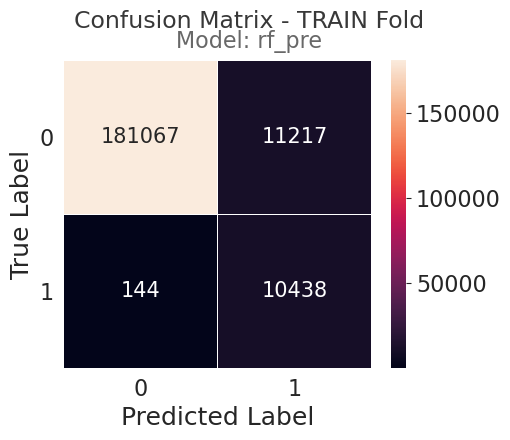

=== rf ===
RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=2, n_estimators=800, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

           0      1.000     0.998     0.999    192284
           1      0.957     0.997     0.976     10582

    accuracy                          0.997    202866
   macro avg      0.978     0.997     0.988    202866
weighted avg      0.998     0.997     0.998    202866



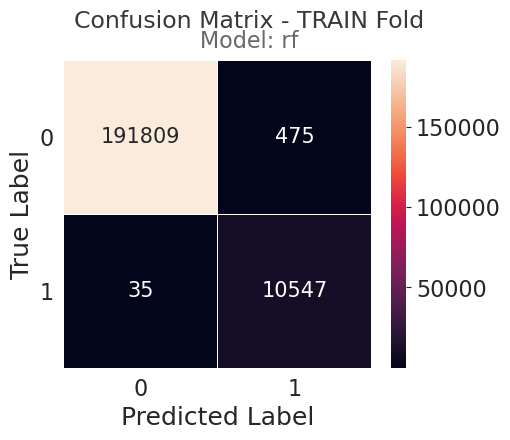

=== xgboost_pre ===
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=800,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)
              precision    recall  f1-score   support

           0      0.993     0.794     0.883    192284
           1      0.194     0.904     0.320     10582

    accuracy                          0.800    202866
   macro avg      0.594     0.849     0.601    202866
weighted avg  

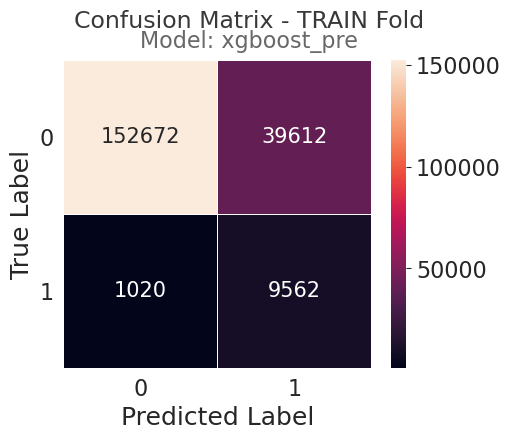

=== xgboost ===
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.5, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=800,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)
              precision    recall  f1-score   support

           0      1.000     0.999     1.000    192284
           1      0.990     0.998     0.994     10582

    accuracy                          0.999    202866
   macro avg      0.995     0.999     0.997    202866
weighted avg   

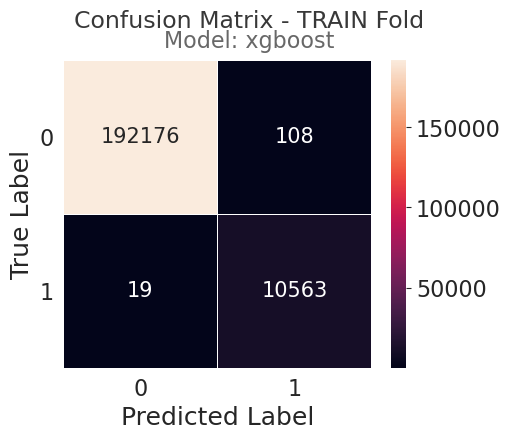

=== hgbc_pre ===
HistGradientBoostingClassifier(max_depth=15, max_iter=500, random_state=42)
              precision    recall  f1-score   support

           0      0.951     0.998     0.974    192284
           1      0.643     0.062     0.114     10582

    accuracy                          0.949    202866
   macro avg      0.797     0.530     0.544    202866
weighted avg      0.935     0.949     0.929    202866



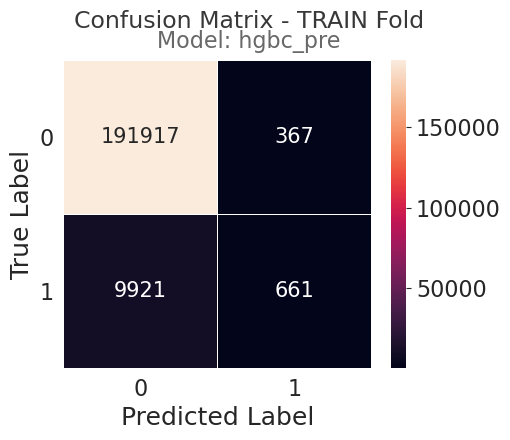

=== hgbc ===
HistGradientBoostingClassifier(max_depth=15, max_iter=500, random_state=42)
              precision    recall  f1-score   support

           0      0.951     0.998     0.974    192284
           1      0.643     0.062     0.114     10582

    accuracy                          0.949    202866
   macro avg      0.797     0.530     0.544    202866
weighted avg      0.935     0.949     0.929    202866



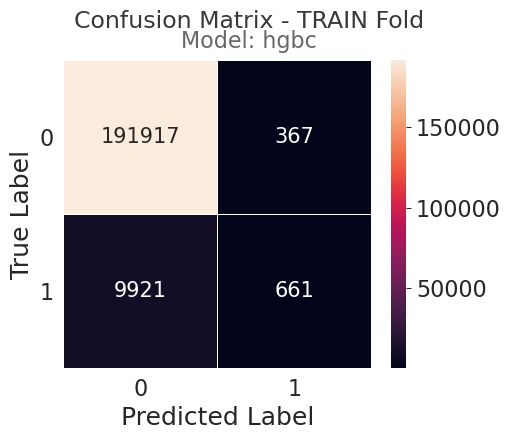

In [73]:
l_train_error = list()

for m_name, d_gs in d_search_fit.items():
    y_pred_ = d_gs.predict(X_train)
    y_true_ = y_train
    print(f"=== {m_name} ===")
    print(d_gs.best_estimator_['clf'])
#     try:
    print(classification_report(y_true_, y_pred=y_pred_, digits=3))
    accuracy_ = accuracy_score(y_true_, y_pred=y_pred_)
        
#     except ValueError:
#         y_pred_ = le.inverse_transform(y_pred_)
#         print(classification_report(y_test, y_pred=y_pred_, labels=le.classes_, digits=3))
#         accuracy_ = accuracy_score(y_test, y_pred=y_pred_)
        
    # save error dataframe
    l_train_error.append(
        {
            'model_name': m_name,
            'error': 1 - accuracy_,
            'accuracy': accuracy_,
            'model_class': str(type(d_gs.best_estimator_['clf'])).split('.')[-1][:-2],
            'model_params': str(d_gs.best_estimator_['clf']).replace('\n', ' '),
        }
    )
    
    # confusion matrix
    conf_mx = confusion_matrix(y_true=y_true_, y_pred=y_pred_, labels=le.classes_)
    mask_exclude = conf_mx == 0
    with sns.axes_style("white"):
        plt.figure(figsize=(5, 4))

        ax = sns.heatmap(
            conf_mx,
            # center=0,
            # cmap=cm.PiYG,
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            annot=True,
            annot_kws={"size": 15},
            mask=mask_exclude,
            square=True,
            fmt="0.0f",
            linewidths=.5,
        )
        plt.yticks(rotation=0)
        # plt.xticks(rotation=45)
        ax.set(
            ylabel='True Label',
            xlabel='Predicted Label',
        )

        plt.figtext(
            .5, .96, f"Confusion Matrix - TRAIN Fold",
            fontsize=17, color='#383838', ha='center'
        );
        plt.figtext(
            .5, .91, f"Model: {m_name}",
            fontsize=16, color='#686868', ha='center'
        )
        plt.show()

In [74]:
# {f"{k}_1": v for k, v in d_clf_report_['1'].items()}
# d_clf_report_

In [75]:
# {
#     **{f"{k}_1": v for k, v in d_clf_report_['1'].items()},
#     **{f"{k}_0": v for k, v in d_clf_report_['0'].items()},
# }


========= rf_pre =========
              precision    recall  f1-score   support

           0      0.969     0.928     0.948     48073
           1      0.261     0.460     0.333      2644

    accuracy                          0.904     50717
   macro avg      0.615     0.694     0.640     50717
weighted avg      0.932     0.904     0.916     50717



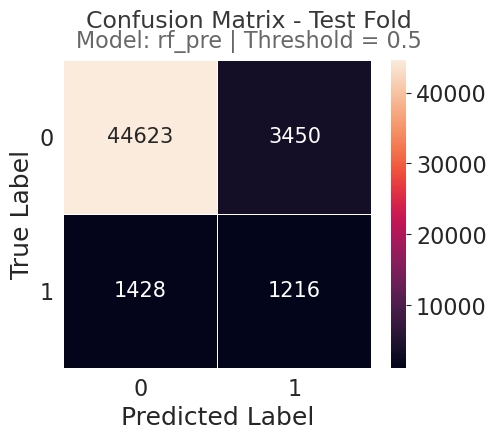

              precision    recall  f1-score   support

           0      0.996     0.580     0.733     48073
           1      0.111     0.954     0.199      2644

    accuracy                          0.600     50717
   macro avg      0.553     0.767     0.466     50717
weighted avg      0.950     0.600     0.705     50717



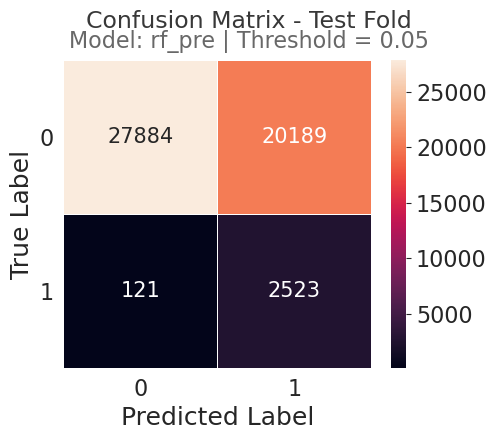

,pred-count,pred-percent,pred-pct_cumulative_sum
0,"46,051",90.8%,90.8%
1,"4,666",9.2%,100.0%


,pred_proba_0.05-count,pred_proba_0.05-percent,pred_proba_0.05-pct_cumulative_sum
0,"28,005",55.2%,55.2%
1,"22,712",44.8%,100.0%



========= rf =========
              precision    recall  f1-score   support

           0      0.956     0.985     0.970     48073
           1      0.387     0.175     0.241      2644

    accuracy                          0.943     50717
   macro avg      0.672     0.580     0.605     50717
weighted avg      0.926     0.943     0.932     50717



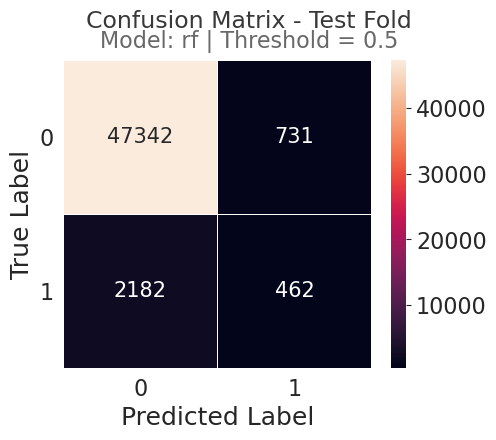

              precision    recall  f1-score   support

           0      0.992     0.646     0.783     48073
           1      0.124     0.910     0.218      2644

    accuracy                          0.660     50717
   macro avg      0.558     0.778     0.500     50717
weighted avg      0.947     0.660     0.753     50717



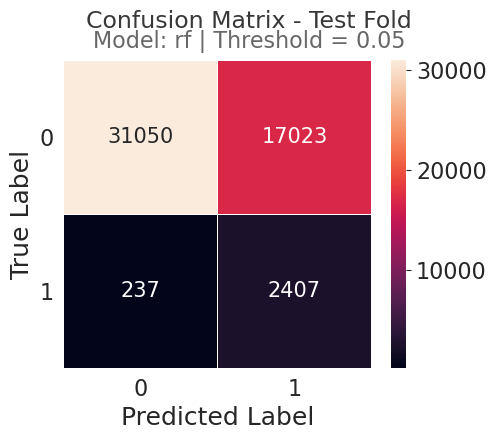

,pred-count,pred-percent,pred-pct_cumulative_sum
0,"49,524",97.6%,97.6%
1,"1,193",2.4%,100.0%


,pred_proba_0.05-count,pred_proba_0.05-percent,pred_proba_0.05-pct_cumulative_sum
0,"31,287",61.7%,61.7%
1,"19,430",38.3%,100.0%



========= xgboost_pre =========
              precision    recall  f1-score   support

           0      0.985     0.786     0.875     48073
           1      0.169     0.787     0.278      2644

    accuracy                          0.786     50717
   macro avg      0.577     0.787     0.576     50717
weighted avg      0.943     0.786     0.844     50717



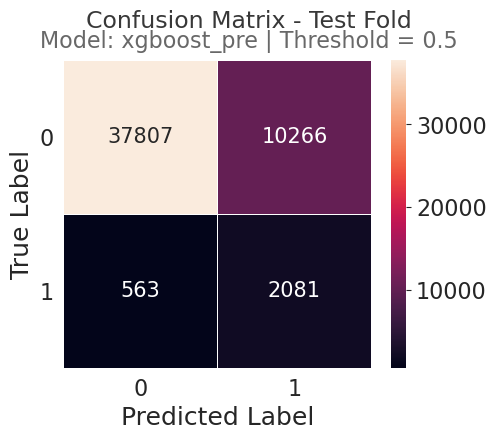

              precision    recall  f1-score   support

           0      0.997     0.352     0.521     48073
           1      0.077     0.981     0.143      2644

    accuracy                          0.385     50717
   macro avg      0.537     0.667     0.332     50717
weighted avg      0.949     0.385     0.501     50717



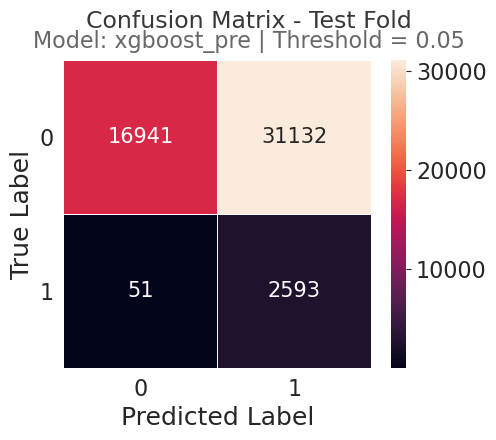

,pred-count,pred-percent,pred-pct_cumulative_sum
0,"38,370",75.7%,75.7%
1,"12,347",24.3%,100.0%


,pred_proba_0.05-count,pred_proba_0.05-percent,pred_proba_0.05-pct_cumulative_sum
1,"33,725",66.5%,66.5%
0,"16,992",33.5%,100.0%



========= xgboost =========
              precision    recall  f1-score   support

           0      0.956     0.982     0.969     48073
           1      0.356     0.176     0.236      2644

    accuracy                          0.940     50717
   macro avg      0.656     0.579     0.602     50717
weighted avg      0.925     0.940     0.931     50717



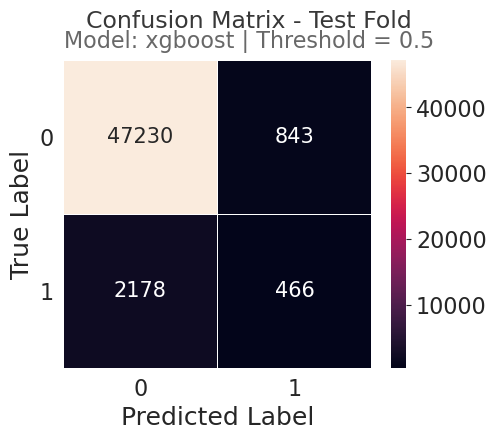

              precision    recall  f1-score   support

           0      0.964     0.932     0.948     48073
           1      0.227     0.362     0.279      2644

    accuracy                          0.903     50717
   macro avg      0.596     0.647     0.614     50717
weighted avg      0.925     0.903     0.913     50717



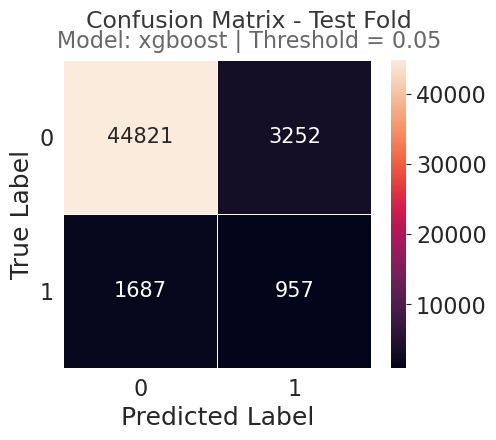

,pred-count,pred-percent,pred-pct_cumulative_sum
0,"49,408",97.4%,97.4%
1,"1,309",2.6%,100.0%


,pred_proba_0.05-count,pred_proba_0.05-percent,pred_proba_0.05-pct_cumulative_sum
0,"46,508",91.7%,91.7%
1,"4,209",8.3%,100.0%



========= hgbc_pre =========
              precision    recall  f1-score   support

           0      0.951     0.998     0.974     48073
           1      0.600     0.062     0.113      2644

    accuracy                          0.949     50717
   macro avg      0.775     0.530     0.543     50717
weighted avg      0.933     0.949     0.929     50717



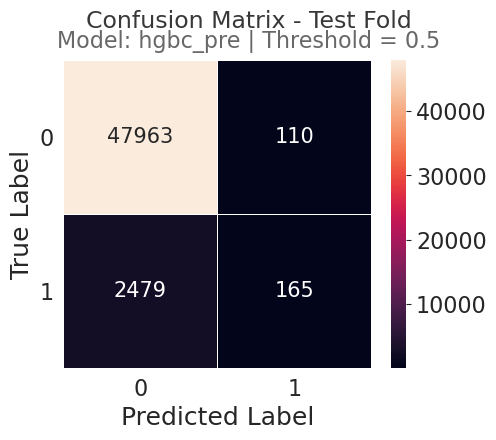

              precision    recall  f1-score   support

           0      0.990     0.737     0.845     48073
           1      0.152     0.858     0.259      2644

    accuracy                          0.744     50717
   macro avg      0.571     0.798     0.552     50717
weighted avg      0.946     0.744     0.814     50717



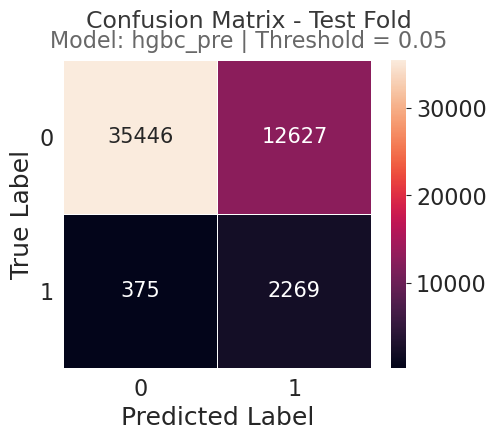

,pred-count,pred-percent,pred-pct_cumulative_sum
0,"50,442",99.5%,99.5%
1,275,0.5%,100.0%


,pred_proba_0.05-count,pred_proba_0.05-percent,pred_proba_0.05-pct_cumulative_sum
0,"35,821",70.6%,70.6%
1,"14,896",29.4%,100.0%



========= hgbc =========
              precision    recall  f1-score   support

           0      0.951     0.998     0.974     48073
           1      0.600     0.062     0.113      2644

    accuracy                          0.949     50717
   macro avg      0.775     0.530     0.543     50717
weighted avg      0.933     0.949     0.929     50717



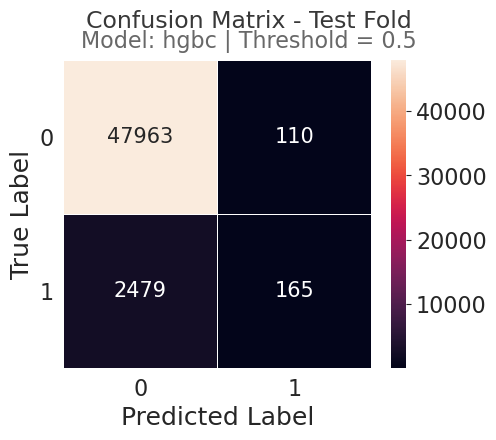

              precision    recall  f1-score   support

           0      0.990     0.737     0.845     48073
           1      0.152     0.858     0.259      2644

    accuracy                          0.744     50717
   macro avg      0.571     0.798     0.552     50717
weighted avg      0.946     0.744     0.814     50717



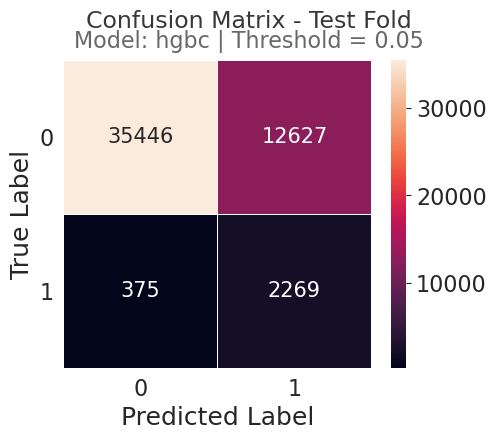

,pred-count,pred-percent,pred-pct_cumulative_sum
0,"50,442",99.5%,99.5%
1,275,0.5%,100.0%


,pred_proba_0.05-count,pred_proba_0.05-percent,pred_proba_0.05-pct_cumulative_sum
0,"35,821",70.6%,70.6%
1,"14,896",29.4%,100.0%


In [155]:
l_test_error = list()
proba_alt_ = 0.05
for m_name, d_gs in d_search_fit.items():
    y_pred_ = d_gs.predict(X_test)
    y_pred_a = (d_gs.predict_proba(X_test)[:,1] >= proba_alt_).astype('int')
    
    print(f"\n========= {m_name} =========")
#     try:
    print(classification_report(y_test, y_pred=y_pred_, digits=3))
    d_clf_report_ = classification_report(y_test, y_pred=y_pred_, digits=3, output_dict=True)
    d_clf_report_proba_ = classification_report(y_test, y_pred=y_pred_a, digits=3, output_dict=True)

    accuracy_ = accuracy_score(y_test, y_pred=y_pred_)
    accuracy_proba_ = accuracy_score(y_test, y_pred=y_pred_a)
        
#     except ValueError:
#         y_pred_ = le.inverse_transform(y_pred_)
#         print(classification_report(y_test, y_pred=y_pred_, labels=le.classes_, digits=3))
#         accuracy_ = accuracy_score(y_test, y_pred=y_pred_)
        
    # save metrics dataframe for threshold=0.5
    l_test_error.append({
        **{
            'model_name': m_name,
            'model_params': str(d_gs.best_estimator_['clf']).replace('\n', ' '),
            'model_class': str(type(d_gs.best_estimator_['clf'])).split('.')[-1][:-2],
            'proba_threshold': 0.5,
        },
        **{f"{k}_1": v for k, v in d_clf_report_['1'].items()},
        **{
            'error': 1 - accuracy_,
            'accuracy': accuracy_,
        },
        **{f"{k}_0": v for k, v in d_clf_report_['0'].items()},
        **{f"{k}_macro_avg": v for k, v in d_clf_report_['macro avg'].items()},
        **{f"{k}_weighted_avg": v for k, v in d_clf_report_['weighted avg'].items()},
    })
    
    # save metrics dataframe for custom threshold
    l_test_error.append({
        **{
            'model_name': m_name,
            'model_params': str(d_gs.best_estimator_['clf']).replace('\n', ' '),
            'model_class': str(type(d_gs.best_estimator_['clf'])).split('.')[-1][:-2],
            'proba_threshold': proba_alt_,
        },
        **{f"{k}_1": v for k, v in d_clf_report_proba_['1'].items()},
        **{
            'error': 1 - accuracy_proba_,
            'accuracy': accuracy_proba_,
        },
        **{f"{k}_0": v for k, v in d_clf_report_proba_['0'].items()},
        **{f"{k}_macro_avg": v for k, v in d_clf_report_proba_['macro avg'].items()},
        **{f"{k}_weighted_avg": v for k, v in d_clf_report_proba_['weighted avg'].items()},
    })
    
    # confusion matrix
    conf_mx = confusion_matrix(y_true=y_test, y_pred=y_pred_, labels=le.classes_)
    mask_exclude = conf_mx == 0
    with sns.axes_style("white"):
        plt.figure(figsize=(5, 4))
        ax = sns.heatmap(
            conf_mx,
            # center=0,
            # cmap=cm.PiYG,
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            annot=True,
            annot_kws={"size": 15},
            mask=mask_exclude,
            square=True,
            fmt="0.0f",
            linewidths=.5,
        )
        plt.yticks(rotation=0)
        # plt.xticks(rotation=45)
        ax.set(
            ylabel='True Label',
            xlabel='Predicted Label',
        )

        plt.figtext(
            .5, .96, f"Confusion Matrix - Test Fold",
            fontsize=17, color='#383838', ha='center'
        );
        plt.figtext(
            .5, .91, f"Model: {m_name} | Threshold = 0.5",
            fontsize=16, color='#686868', ha='center'
        )
        plt.show()
        
    print(classification_report(y_test, y_pred=y_pred_a, digits=3))
    conf_mx = confusion_matrix(y_true=y_test, y_pred=y_pred_a, labels=le.classes_)
    mask_exclude = conf_mx == 0
    with sns.axes_style("white"):
        plt.figure(figsize=(5, 4))
        ax = sns.heatmap(
            conf_mx,
            # center=0,
            # cmap=cm.PiYG,
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            annot=True,
            annot_kws={"size": 15},
            mask=mask_exclude,
            square=True,
            fmt="0.0f",
            linewidths=.5,
        )
        plt.yticks(rotation=0)
        # plt.xticks(rotation=45)
        ax.set(
            ylabel='True Label',
            xlabel='Predicted Label',
        )

        plt.figtext(
            .5, .96, f"Confusion Matrix - Test Fold",
            fontsize=17, color='#383838', ha='center'
        );
        plt.figtext(
            .5, .91, f"Model: {m_name} | Threshold = {proba_alt_}",
            fontsize=16, color='#686868', ha='center'
        )
        plt.show()
    
    display(
        value_counts_and_pcts(
            pd.Series(y_pred_, name='pred').to_frame(),
            'pred',
        )
    )
    display(
        value_counts_and_pcts(
            pd.Series(y_pred_a, name=f'pred_proba_{proba_alt_}').to_frame(),
            f'pred_proba_{proba_alt_}',
        )
    )


========= rf_pre =========
              precision    recall  f1-score   support

           0      0.979     0.851     0.911     48073
           1      0.199     0.674     0.307      2644

    accuracy                          0.842     50717
   macro avg      0.589     0.762     0.609     50717
weighted avg      0.939     0.842     0.879     50717



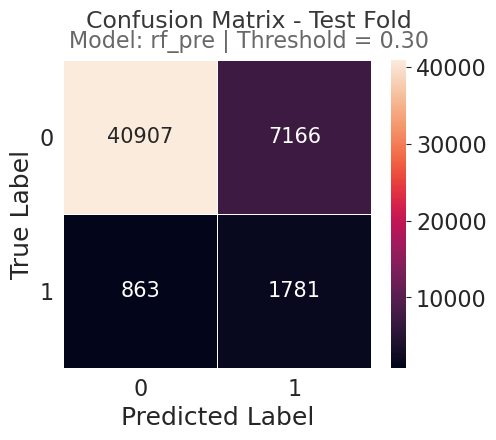

,pred-count,pred-percent,pred-pct_cumulative_sum
0,"50,442",99.5%,99.5%
1,275,0.5%,100.0%


,pred_proba_0.3-count,pred_proba_0.3-percent,pred_proba_0.3-pct_cumulative_sum
0,"41,770",82.4%,82.4%
1,"8,947",17.6%,100.0%



========= xgboost_pre =========
              precision    recall  f1-score   support

           0      0.992     0.662     0.794     48073
           1      0.129     0.906     0.225      2644

    accuracy                          0.675     50717
   macro avg      0.560     0.784     0.510     50717
weighted avg      0.947     0.675     0.765     50717



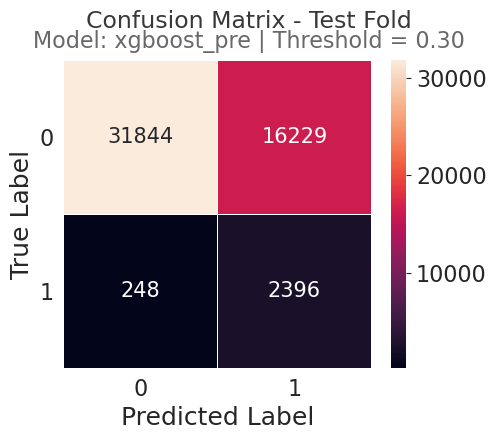

,pred-count,pred-percent,pred-pct_cumulative_sum
0,"50,442",99.5%,99.5%
1,275,0.5%,100.0%


,pred_proba_0.3-count,pred_proba_0.3-percent,pred_proba_0.3-pct_cumulative_sum
0,"32,092",63.3%,63.3%
1,"18,625",36.7%,100.0%


In [161]:
# l_test_error = list()
proba_alt_ = 0.3

for m_name, d_gs in d_search_fit.items():
    if m_name not in ['xgboost_pre', 'rf_pre']:
        continue
    y_pred_a = (d_gs.predict_proba(X_test)[:,1] >= proba_alt_).astype('int')
    
    print(f"\n========= {m_name} =========")
    d_clf_report_proba_ = classification_report(y_test, y_pred=y_pred_a, digits=3, output_dict=True)

    accuracy_proba_ = accuracy_score(y_test, y_pred=y_pred_a)
    
    # save metrics dataframe for custom threshold
    l_test_error.append({
        **{
            'model_name': m_name,
            'model_params': str(d_gs.best_estimator_['clf']).replace('\n', ' '),
            'model_class': str(type(d_gs.best_estimator_['clf'])).split('.')[-1][:-2],
            'proba_threshold': proba_alt_,
        },
        **{f"{k}_1": v for k, v in d_clf_report_proba_['1'].items()},
        **{
            'error': 1 - accuracy_proba_,
            'accuracy': accuracy_proba_,
        },
        **{f"{k}_0": v for k, v in d_clf_report_proba_['0'].items()},
        **{f"{k}_macro_avg": v for k, v in d_clf_report_proba_['macro avg'].items()},
        **{f"{k}_weighted_avg": v for k, v in d_clf_report_proba_['weighted avg'].items()},
    })
        
    print(classification_report(y_test, y_pred=y_pred_a, digits=3))
    conf_mx = confusion_matrix(y_true=y_test, y_pred=y_pred_a, labels=le.classes_)
    mask_exclude = conf_mx == 0
    with sns.axes_style("white"):
        plt.figure(figsize=(5, 4))
        ax = sns.heatmap(
            conf_mx,
            # center=0,
            # cmap=cm.PiYG,
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            annot=True,
            annot_kws={"size": 15},
            mask=mask_exclude,
            square=True,
            fmt="0.0f",
            linewidths=.5,
        )
        plt.yticks(rotation=0)
        # plt.xticks(rotation=45)
        ax.set(
            ylabel='True Label',
            xlabel='Predicted Label',
        )

        plt.figtext(
            .5, .96, f"Confusion Matrix - Test Fold",
            fontsize=17, color='#383838', ha='center'
        );
        plt.figtext(
            .5, .91, f"Model: {m_name} | Threshold = {proba_alt_:,.2f}",
            fontsize=16, color='#686868', ha='center'
        )
        plt.show()
    
    display(
        value_counts_and_pcts(
            pd.Series(y_pred_, name='pred').to_frame(),
            'pred',
        )
    )
    display(
        value_counts_and_pcts(
            pd.Series(y_pred_a, name=f'pred_proba_{proba_alt_}').to_frame(),
            f'pred_proba_{proba_alt_}',
        )
    )

## Plot table of errors by model type

In [157]:
# CTR for users that the model picks would be:
false_pred_clicks_ = 16682
true_pred_clicks_ = 2382
total_selected = (false_pred_clicks_ + true_pred_clicks_)

pct_selected_to_send = total_selected / len(X_test)
total_projected_send = len(df_train) * pct_selected_to_send
print(f"Total sends (test): {total_selected:,.0f}")
print(f"Sends as Percent of actual: {pct_selected_to_send:,.2%}")
print(f"Total Receives: {len(df_train):,.0f}")
print(f"Total Sends Projected: {total_projected_send:,.0f}")

print(f"New CTR: {true_pred_clicks_ / total_selected:,.2%}")

Total sends (test): 19,064
Sends as Percent of actual: 37.59%
Total Receives: 253,583
Total Sends Projected: 95,319
New CTR: 12.49%


In [158]:
# original CTR
value_counts_and_pcts(
    df_train,
    ['click'],
    sort_index=True,
    top_n=None,
)

,count,percent,cumulative_percent
click,,,
1,"13,226",5.2%,5.2%
0,"240,357",94.8%,100.0%


In [162]:
df_error_test = (
    pd.DataFrame(l_test_error)
    .sort_values(by=['recall_1'], ascending=False,)
)
df_error_test['model_params'] = (
    df_error_test['model_params']
    .str.replace('[\w]{2,25}=None,', '', regex=True)
    .str.replace('[\w]{2,25}=-?[01],', '', regex=True)
    .str.replace("[\w]{2,25}='auto',", '', regex=True)
    .str.replace("[\w]{2,25}=nan,", '', regex=True)
    .str.replace("[\w]{2,25}='',", '', regex=True)
    .str.replace("[\w]{2,35}='()',", '', regex=True)
)

display(
    style_df_numeric(
        df_error_test
        .drop(
            [_ for _ in df_error_test.columns if any([_.endswith(v_) for v_ in ['_0', '_avg']])],
            axis=1,
        ),
        float_round=3,
        l_bar_simple=['precision_1', 'recall_1', 'f1-score_1', 'error'],
    ).set_caption(f"<h3 align='left'>Holdout/Test Results</h2>")
)

style_df_numeric(
    df_error_test.drop(['model_params', 'model_name'], axis=1),
    float_round=3,
    l_bar_simple=['precision_1', 'recall_1', 'f1-score_1', 'error'],
).set_caption(f"<h3 align='left'>Holdout/Test Results</h2>")


,model_name,model_params,model_class,proba_threshold,precision_1,recall_1,f1-score_1,support_1,error,accuracy
5,xgboost_pre,"XGBClassifier(base_score=0.5, booster='gbtree', enable_categorical=False, eval_metric='auc', grow_policy='depthwise', learning_rate=0.1, max_bin=256, max_cat_to_onehot=4, max_depth=4, monotone_constraints='()', n_estimators=800, random_state=42, ...)",XGBClassifier,0.050,0.077,0.981,0.143,"2,644",0.615,0.385
1,rf_pre,"RandomForestClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=2, n_estimators=800, random_state=42)",RandomForestClassifier,0.050,0.111,0.954,0.199,"2,644",0.400,0.600
15,xgboost_pre,"XGBClassifier(base_score=0.5, booster='gbtree', enable_categorical=False, eval_metric='auc', grow_policy='depthwise', learning_rate=0.1, max_bin=256, max_cat_to_onehot=4, max_depth=4, monotone_constraints='()', n_estimators=800, random_state=42, ...)",XGBClassifier,0.200,0.115,0.942,0.204,"2,644",0.382,0.618
13,xgboost_pre,"XGBClassifier(base_score=0.5, booster='gbtree', enable_categorical=False, eval_metric='auc', grow_policy='depthwise', learning_rate=0.1, max_bin=256, max_cat_to_onehot=4, max_depth=4, monotone_constraints='()', n_estimators=800, random_state=42, ...)",XGBClassifier,0.250,0.122,0.924,0.215,"2,644",0.352,0.648
3,rf,"RandomForestClassifier(class_weight='balanced', max_depth=30, min_samples_leaf=2, n_estimators=800, random_state=42)",RandomForestClassifier,0.050,0.124,0.910,0.218,"2,644",0.340,0.660
17,xgboost_pre,"XGBClassifier(base_score=0.5, booster='gbtree', enable_categorical=False, eval_metric='auc', grow_policy='depthwise', learning_rate=0.1, max_bin=256, max_cat_to_onehot=4, max_depth=4, monotone_constraints='()', n_estimators=800, random_state=42, ...)",XGBClassifier,0.300,0.129,0.906,0.225,"2,644",0.325,0.675
11,hgbc,"HistGradientBoostingClassifier(max_depth=15, max_iter=500, random_state=42)",HistGradientBoostingClassifier,0.050,0.152,0.858,0.259,"2,644",0.256,0.744
9,hgbc_pre,"HistGradientBoostingClassifier(max_depth=15, max_iter=500, random_state=42)",HistGradientBoostingClassifier,0.050,0.152,0.858,0.259,"2,644",0.256,0.744
14,rf_pre,"RandomForestClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=2, n_estimators=800, random_state=42)",RandomForestClassifier,0.200,0.168,0.791,0.277,"2,644",0.216,0.784
4,xgboost_pre,"XGBClassifier(base_score=0.5, booster='gbtree', enable_categorical=False, eval_metric='auc', grow_policy='depthwise', learning_rate=0.1, max_bin=256, max_cat_to_onehot=4, max_depth=4, monotone_constraints='()', n_estimators=800, random_state=42, ...)",XGBClassifier,0.500,0.169,0.787,0.278,"2,644",0.214,0.786


,model_class,proba_threshold,precision_1,recall_1,f1-score_1,support_1,error,accuracy,precision_0,recall_0,f1-score_0,support_0,precision_macro_avg,recall_macro_avg,f1-score_macro_avg,support_macro_avg,precision_weighted_avg,recall_weighted_avg,f1-score_weighted_avg,support_weighted_avg
5,XGBClassifier,0.050,0.077,0.981,0.143,"2,644",0.615,0.385,0.997,0.352,0.521,"48,073",0.537,0.667,0.332,"50,717",0.949,0.385,0.501,"50,717"
1,RandomForestClassifier,0.050,0.111,0.954,0.199,"2,644",0.400,0.600,0.996,0.580,0.733,"48,073",0.553,0.767,0.466,"50,717",0.950,0.600,0.705,"50,717"
15,XGBClassifier,0.200,0.115,0.942,0.204,"2,644",0.382,0.618,0.995,0.600,0.749,"48,073",0.555,0.771,0.476,"50,717",0.949,0.618,0.720,"50,717"
13,XGBClassifier,0.250,0.122,0.924,0.215,"2,644",0.352,0.648,0.993,0.633,0.773,"48,073",0.558,0.779,0.494,"50,717",0.948,0.648,0.744,"50,717"
3,RandomForestClassifier,0.050,0.124,0.910,0.218,"2,644",0.340,0.660,0.992,0.646,0.783,"48,073",0.558,0.778,0.500,"50,717",0.947,0.660,0.753,"50,717"
17,XGBClassifier,0.300,0.129,0.906,0.225,"2,644",0.325,0.675,0.992,0.662,0.794,"48,073",0.560,0.784,0.510,"50,717",0.947,0.675,0.765,"50,717"
11,HistGradientBoostingClassifier,0.050,0.152,0.858,0.259,"2,644",0.256,0.744,0.990,0.737,0.845,"48,073",0.571,0.798,0.552,"50,717",0.946,0.744,0.814,"50,717"
9,HistGradientBoostingClassifier,0.050,0.152,0.858,0.259,"2,644",0.256,0.744,0.990,0.737,0.845,"48,073",0.571,0.798,0.552,"50,717",0.946,0.744,0.814,"50,717"
14,RandomForestClassifier,0.200,0.168,0.791,0.277,"2,644",0.216,0.784,0.986,0.784,0.873,"48,073",0.577,0.787,0.575,"50,717",0.943,0.784,0.842,"50,717"
4,XGBClassifier,0.500,0.169,0.787,0.278,"2,644",0.214,0.786,0.985,0.786,0.875,"48,073",0.577,0.787,0.576,"50,717",0.943,0.786,0.844,"50,717"


In [141]:
d_search_fit['xgboost_pre'].best_params_

{'clf__eval_metric': 'auc',
 'clf__learning_rate': 0.1,
 'clf__max_depth': 4,
 'clf__min_child_weight': 1,
 'clf__n_estimators': 800}

In [143]:
d_search_fit['xgboost_pre'].best_estimator_['clf'].get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'eval_metric': 'auc',
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 4,
 'max_leaves': 0,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 18.170856170856172,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [140]:
for p_ in d_search_fit['xgboost_pre'].best_estimator_:
    print(p_)

ColumnTransformer(remainder='passthrough',
                  transformers=[('scale', StandardScaler(),
                                 ['tos_sub_count', 'user_receives_pn_t7',
                                  'user_clicks_pn_t7', 'user_clicks_trnd_t7',
                                  'screen_view_count_14d', 'num_post_consumes',
                                  'num_post_consumes_home',
                                  'num_post_consumes_community',
                                  'num_post_consumes_post_detail',
                                  'num_post_consumes_ios',
                                  'num_post_consumes_android',
                                  'num_post_consumes_nsfw',
                                  'pct_post_consumes_nsfw',
                                  'view_and_consume_unique_count',
                                  'consume_unique_count', 'view_count',
                                  'consume_count', 'consume_ios_count',
                    

# Check proba outputs


=== rf_pre ===


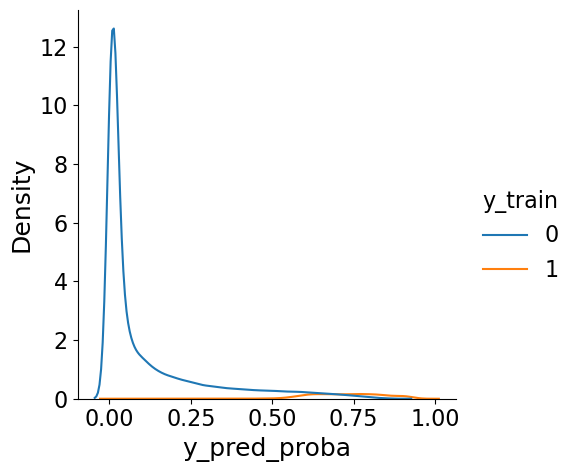

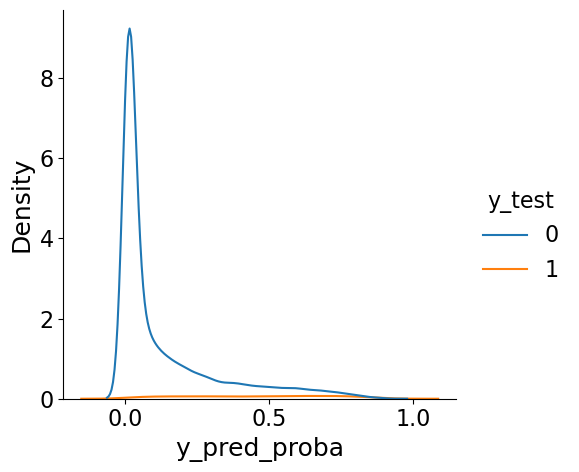


=== rf ===


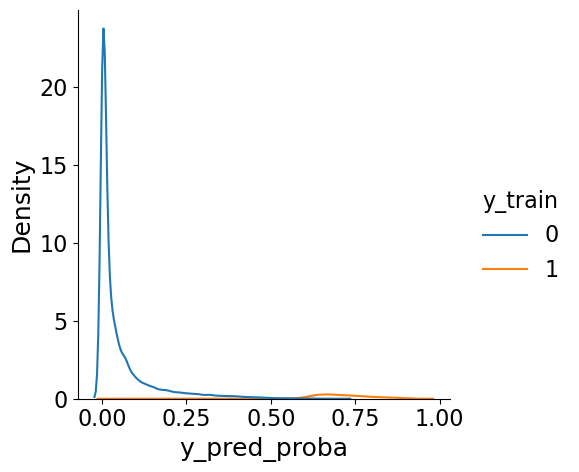

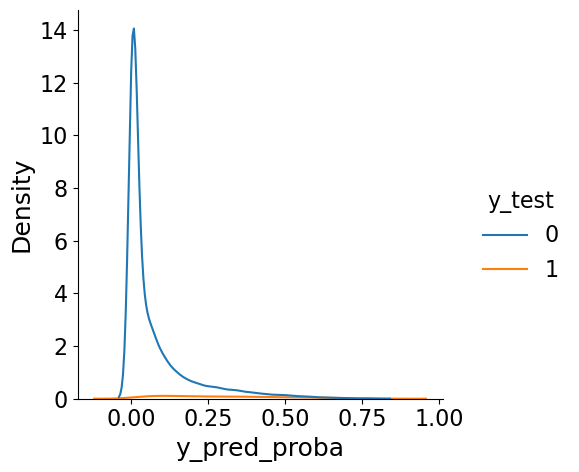


=== xgboost_pre ===


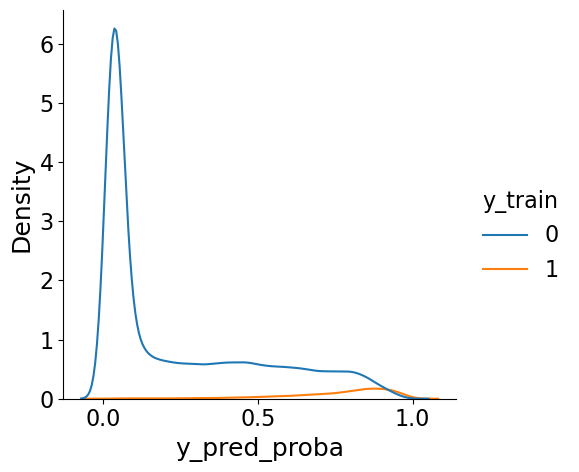

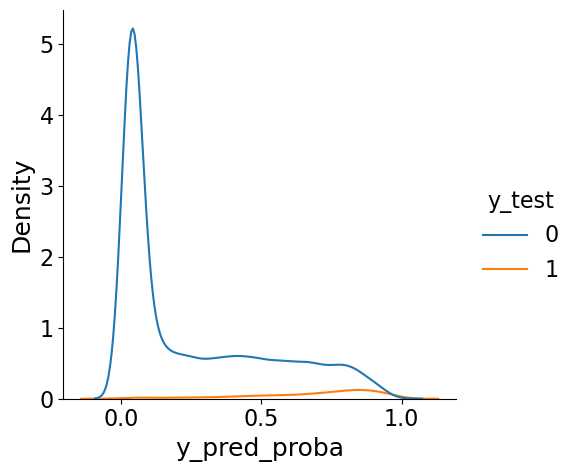


=== xgboost ===


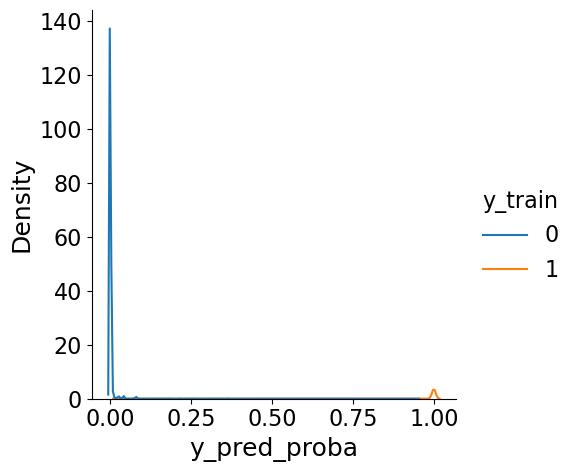

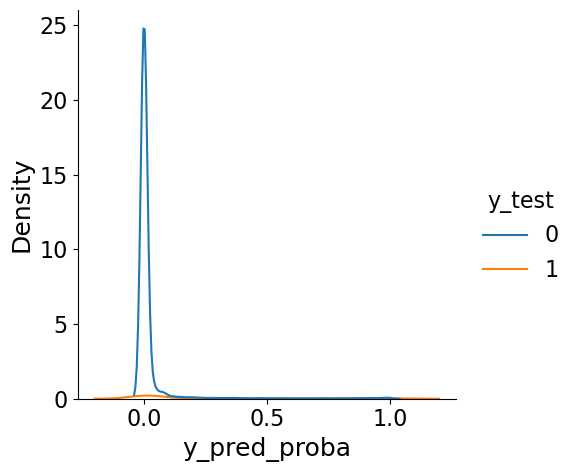


=== hgbc_pre ===


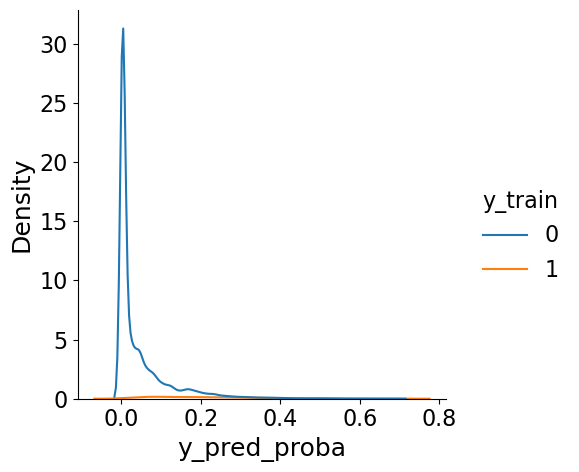

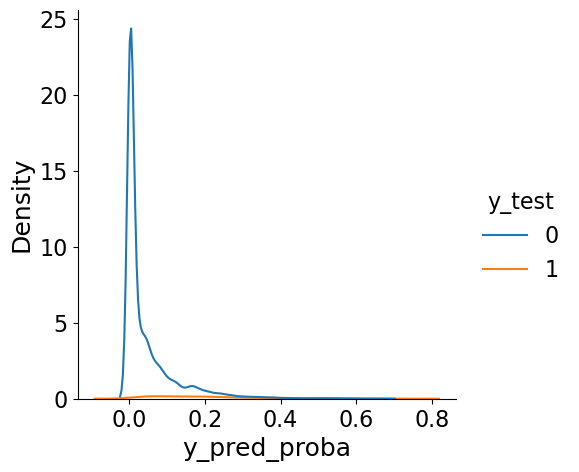


=== hgbc ===


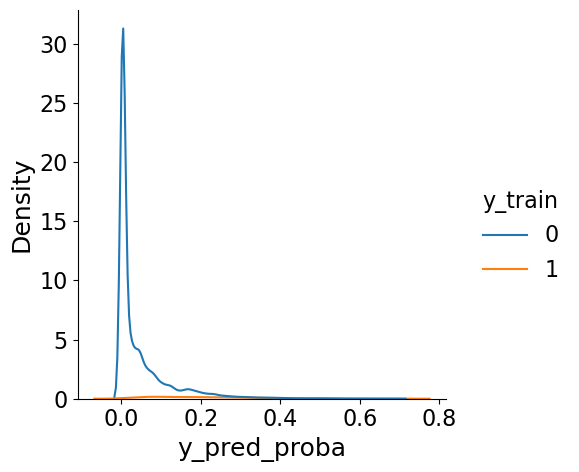

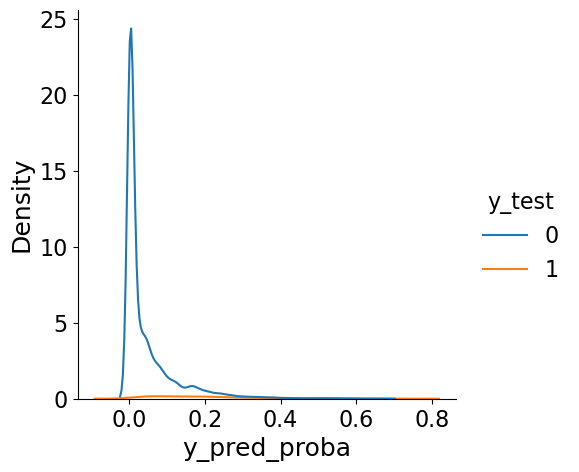

In [80]:
for m_name, d_gs in d_search_fit.items():
    print(f"\n=== {m_name} ===")
    df_y_test_ = pd.DataFrame(
        {
            'y_test': y_test,
            'y_pred_proba': d_gs.predict_proba(X_test)[:, 1],
        }
    )
    df_y_train_ = pd.DataFrame(
        {
            'y_train': y_train,
            'y_pred_proba': d_gs.predict_proba(X_train)[:, 1],
        }
    )
    sns.displot(data=df_y_train_, x="y_pred_proba", kind='kde', hue='y_train')
    plt.show()
    
    sns.displot(data=df_y_test_, x="y_pred_proba", kind='kde', hue='y_test')
    plt.show()

In [81]:
(
    df_y_test_
    .sort_values(['y_pred_proba'], ascending=False)
).head(20)

,y_test,y_pred_proba
5873,1,0.724904
8128,1,0.690810
4593,1,0.688543
9282,1,0.687711
1278,1,0.685643
6240,1,0.683145
6571,1,0.680059
7046,1,0.676789
70614,0,0.675481
5949,1,0.671888


In [82]:
(
    df_y_test_
    [df_y_test_['y_test'] == 1]
    .sort_values(['y_pred_proba'], ascending=False)
).tail(20)

,y_test,y_pred_proba
9063,1,0.002905
6986,1,0.002837
6471,1,0.002805
607,1,0.002790
12442,1,0.002777
1892,1,0.002721
846,1,0.002669
2885,1,0.002656
13198,1,0.002571
13091,1,0.002555


# Get feature importance
Might help us better select which columns to use for additional stratification

In [83]:
# d_gs.best_estimator_['preprocess'].transformers_

In [89]:
# d_gs.best_estimator_['preprocess'].transformers_[0]

## Impurity & Gain based importance
Note that these may not be the best approach when we have features with high cardinality

In [90]:
from xgboost import plot_importance

In [91]:
d_search_fit['xgboost'].best_estimator_['clf'].get_booster().get_score(importance_type='weight').values()

dict_values([962.0, 14756.0, 12294.0, 7379.0, 5824.0, 5202.0, 12730.0, 15163.0, 16867.0, 1135.0, 2132.0, 10634.0, 11482.0, 14477.0, 4955.0, 3171.0, 5836.0, 5057.0, 937.0, 4616.0])


=== rf_pre ====


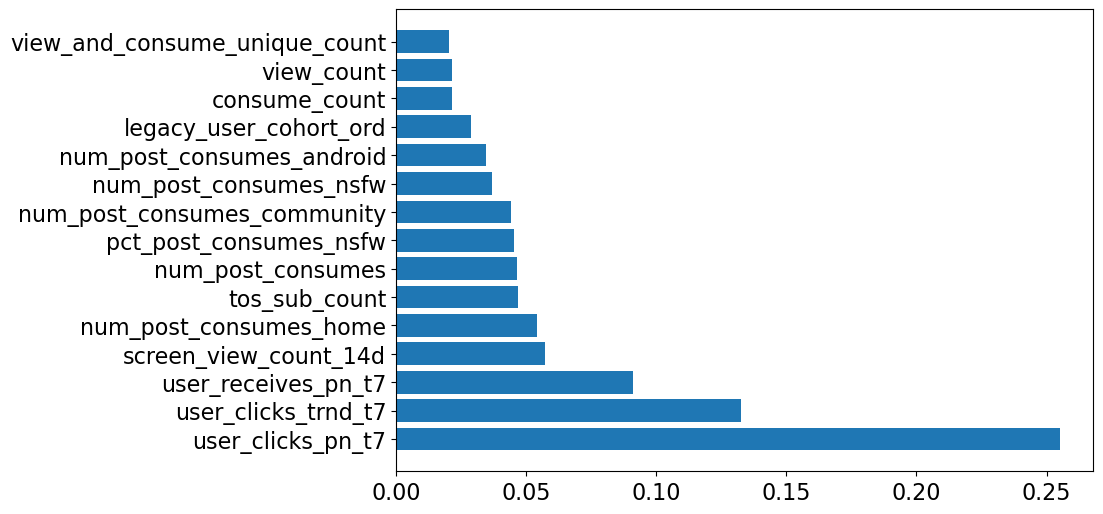

,feature_names,importances,std
2,user_clicks_pn_t7,0.255236,0.113065
3,user_clicks_trnd_t7,0.132541,0.097161
1,user_receives_pn_t7,0.091102,0.015580
4,screen_view_count_14d,0.057254,0.054169
6,num_post_consumes_home,0.054311,0.022149
0,tos_sub_count,0.046733,0.016756
5,num_post_consumes,0.046370,0.014134
12,pct_post_consumes_nsfw,0.045283,0.009601
7,num_post_consumes_community,0.044105,0.012404
11,num_post_consumes_nsfw,0.036767,0.003919


(20, 3)

=== rf ====


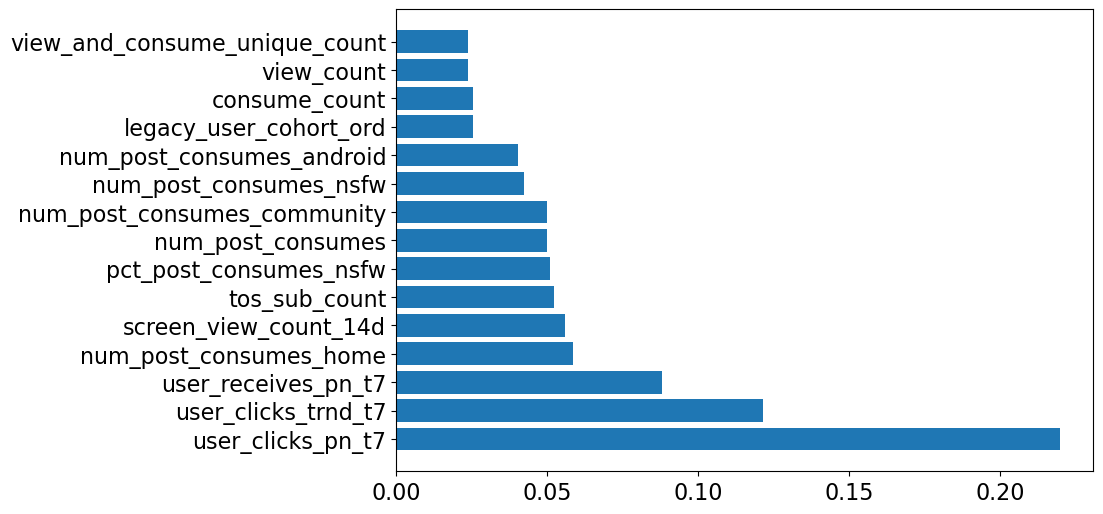

,feature_names,importances,std
3,user_clicks_pn_t7,0.219991,0.095487
4,user_clicks_trnd_t7,0.121608,0.082837
2,user_receives_pn_t7,0.087993,0.013238
7,num_post_consumes_home,0.058486,0.018447
5,screen_view_count_14d,0.056136,0.049663
1,tos_sub_count,0.052265,0.014196
13,pct_post_consumes_nsfw,0.050945,0.008767
6,num_post_consumes,0.050095,0.010363
8,num_post_consumes_community,0.050046,0.010302
12,num_post_consumes_nsfw,0.042479,0.003425


(20, 3)

=== xgboost_pre ====


,feature_names,importances_gain,importances_total_gain,importances_cover,importances_total_cover
2,user_clicks_pn_t7,987.25,"813,491.62","15,014.83","12,372,217.00"
1,user_receives_pn_t7,266.69,"219,215.98","14,537.71","11,949,999.00"
6,num_post_consumes_home,53.69,"46,875.32","14,028.57","12,246,942.00"
3,user_clicks_trnd_t7,51.29,"18,927.49","8,590.67","3,169,955.25"
4,screen_view_count_14d,47.73,"14,509.99","11,146.99","3,388,685.75"
19,legacy_user_cohort_ord,41.34,"4,175.34","10,591.63","1,069,755.12"
9,num_post_consumes_ios,41.11,"14,841.95","25,462.51","9,191,966.00"
12,pct_post_consumes_nsfw,40.03,"44,831.10","18,418.92","20,629,194.00"
5,num_post_consumes,34.65,"31,535.76","15,148.13","13,784,795.00"
10,num_post_consumes_android,34.32,"19,494.49","19,652.36","11,162,541.00"


(20, 5)

=== xgboost ====


,feature_names,importances_gain,importances_total_gain,importances_cover,importances_total_cover
3,user_clicks_pn_t7,29.95,"221,009.31",388.61,"2,867,577.25"
2,user_receives_pn_t7,6.86,"84,370.62",181.58,"2,232,390.75"
9,num_post_consumes_post_detail,4.67,"5,296.67",468.76,"532,043.31"
18,consume_ios_count,4.57,"4,284.21",486.07,"455,450.06"
10,num_post_consumes_ios,4.10,"8,749.63",429.15,"914,944.50"
0,legacy_user_cohort_ord,3.47,"3,334.59",245.50,"236,175.42"
5,screen_view_count_14d,3.04,"15,829.84",125.19,"651,250.00"
7,num_post_consumes_home,3.00,"45,449.82",174.23,"2,641,818.00"
6,num_post_consumes,2.89,"36,728.50",203.21,"2,586,819.25"
13,pct_post_consumes_nsfw,2.85,"41,188.44",207.21,"2,999,724.25"


(20, 5)

=== hgbc_pre ====

=== hgbc ====


In [117]:
d_df_importances = dict()

for m_name, d_gs in d_search_fit.items():
    print(f"\n=== {m_name} ====")
    # try to get feature names from pipeline, otherwise from X_train
    try:
        ftr_names_ = d_gs.best_estimator_['preprocess'].get_feature_names_out()
        # sometimes there are doudlle underscores if we used an encoder like: OneHotEncoder
        ftr_names_ = [
            '__'.join(_.split('__')[1:]) if '__' in _ else _ for _ in ftr_names_
        ]
    except KeyError:
        ftr_names_ = list(X_train.columns)
        
    if type(d_gs.best_estimator_['clf']) in [RandomForestClassifier,]:
        df_importances = (
            pd.DataFrame(
                {
                    'feature_names': ftr_names_,
                    'importances': d_gs.best_estimator_['clf'].feature_importances_,
                    'std': np.std([tree.feature_importances_ for tree in d_gs.best_estimator_['clf'].estimators_], axis=0),
                }
            )
            .sort_values(by=['importances'], ascending=False)
        )
        plt.barh(
            y=df_importances.head(15)['feature_names'],
            width=df_importances.head(15)['importances'],
            # xerr=df_importances.head(15)['std'],
        )
        plt.show()
        display(
            df_importances.head(15)
        )
        print(df_importances.shape)

    elif type(d_gs.best_estimator_['clf']) in [XGBClassifier]:
        # XGBoost: We don't trust the default value b/c it's weights by split
        # plot_importance(d_gs.best_estimator_['clf'])
        plt.show()
        # we need to replace the values because XGBoost will not return features if the importance is zero (no splits)
        
        d_feat_to_name = {
            f"f{i}": v for i, v in enumerate(ftr_names_)
        }
        df_importances = pd.DataFrame({'feature_names': ftr_names_})
        l_imp_cols = list()
        for imp_typ_ in ['gain', 'total_gain', 'cover', 'total_cover']:
            c_imp_typ_ = f'importances_{imp_typ_}'
            l_imp_cols.append(c_imp_typ_)
            
            df_importances = df_importances.merge(
                pd.DataFrame(
                    {
                        c_imp_typ_: d_gs.best_estimator_['clf'].get_booster().get_score(importance_type=imp_typ_).values(),
                    },
                    index=[d_feat_to_name.get(k, k) for k in d_gs.best_estimator_['clf'].get_booster().get_score(importance_type='weight').keys()]
                ),
                how='outer',
                left_on=['feature_names'],
                right_index=True,
            )
        df_importances = df_importances.sort_values(l_imp_cols[0], ascending=False)
        display(
            style_df_numeric(
                df_importances.head(15),
                l_bar_simple=l_imp_cols,
            )
        )
        print(df_importances.shape)
        
    d_df_importances[m_name] = df_importances
    

In [ ]:
# ax = sns.barplot(
#     data=df_importances.head(15),
#     x='importances',
#     y='feature_names',
# )

In [ ]:

# plt.barh(
#     y=df_importances.head(15)['feature_names'],
#     width=df_importances.head(15)['importances'],
#     xerr=df_importances.head(15)['std'],
# )

# EDA - feature correlation for feature selection
It's possible some features are adding noise & hurting model performance, so let's check them out & exclude those with low gain and high correlation to features that are already important

In [122]:
from matplotlib import cm

In [119]:
print(d_df_importances['xgboost_pre'].shape)
d_df_importances['xgboost_pre']['feature_names'].to_list()


(20, 5)


['user_clicks_pn_t7',
 'user_receives_pn_t7',
 'num_post_consumes_home',
 'user_clicks_trnd_t7',
 'screen_view_count_14d',
 'legacy_user_cohort_ord',
 'num_post_consumes_ios',
 'pct_post_consumes_nsfw',
 'num_post_consumes',
 'num_post_consumes_android',
 'consume_unique_count',
 'num_post_consumes_nsfw',
 'view_count',
 'num_post_consumes_community',
 'tos_sub_count',
 'consume_ios_count',
 'view_and_consume_unique_count',
 'consume_count',
 'consume_android_count',
 'num_post_consumes_post_detail']

In [123]:
l_cols_train_ordered = [
    'user_clicks_pn_t7',
    'user_receives_pn_t7',
    'num_post_consumes_home',
    'user_clicks_trnd_t7',
    'screen_view_count_14d',
    'legacy_user_cohort_ord',
    'num_post_consumes_ios',
    'pct_post_consumes_nsfw',
    'num_post_consumes',
    'num_post_consumes_android',
    'consume_unique_count',
    'num_post_consumes_nsfw',
    'view_count',
    'num_post_consumes_community',
    'tos_sub_count',
    'consume_ios_count',
    'view_and_consume_unique_count',
    'consume_count',
    'consume_android_count',
    'num_post_consumes_post_detail'
][::-1]

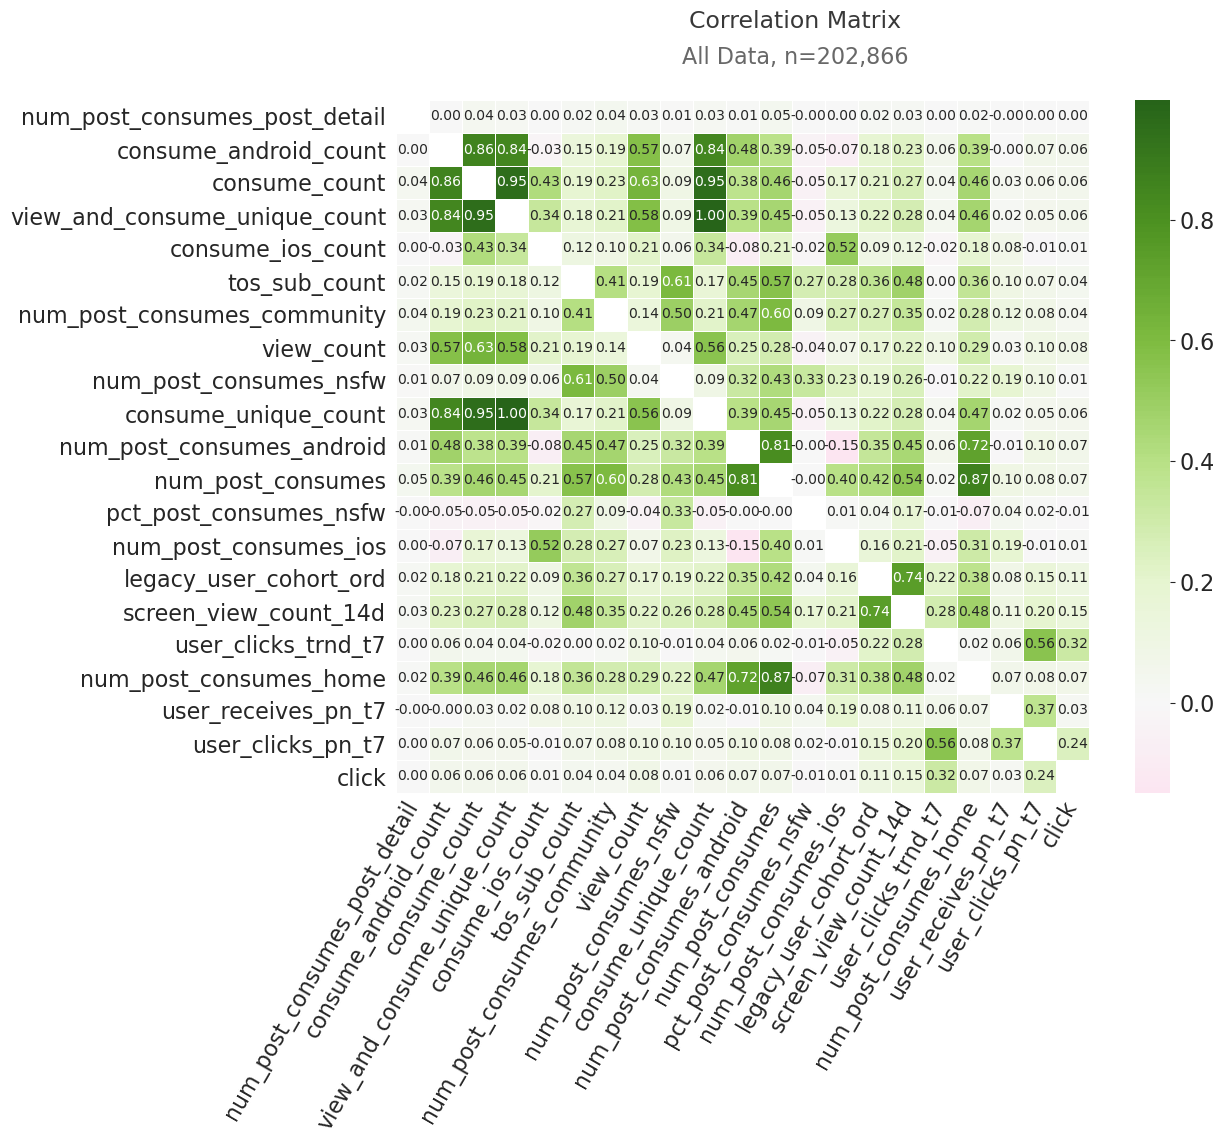

In [124]:
# Use this one that only keeps items below diagonal
#   it's also centered on zero so it's less skewed
plt.figure(figsize=(12, 9))
mask_type = 'diag'  # 'triangle' or 'diag'

# Create final corrmat sorted by most correlated to feature importance
#.  pull feature imporance from above step(s)
#. show in reverse importance so that we see most important features at bottom (long) & it's easier to read correlation cols
corrmat = (
    pd.concat(
        [X_train[l_cols_train_ordered], y_train],
        axis=1,
    )
    .corr()
)
mask = np.zeros_like(corrmat)
if mask_type == 'triangle':
    # For triangle:
    mask[np.triu_indices_from(mask)] = True
elif mask_type == 'diag':
    # Exclude only the diagonal:
    np.fill_diagonal(mask, 1.0)

with sns.axes_style("white"):
    sns.heatmap(
        corrmat, center=0,
        cmap=cm.PiYG,
        mask=mask,
        annot=True,
        annot_kws={"size": 10},
        square=True,
        fmt="0.2f",
        linewidths=.5,
    )
    plt.yticks(rotation=0)
    plt.xticks(rotation=60, va='center', ha='right', rotation_mode='anchor')

    plt.figtext(
        .5, .96, f"Correlation Matrix",
        fontsize=17, color='#383838', ha='center'
    );
    plt.figtext(
        .5, .92, f"All Data, n={len(X_train):,.0f}",
        fontsize=16, color='#686868', ha='center'
    )
plt.show()

Cols to exclude:
['num_post_consumes_nsfw', 'view_and_consume_unique_count', 'view_count', 'num_post_consumes_post_detail']


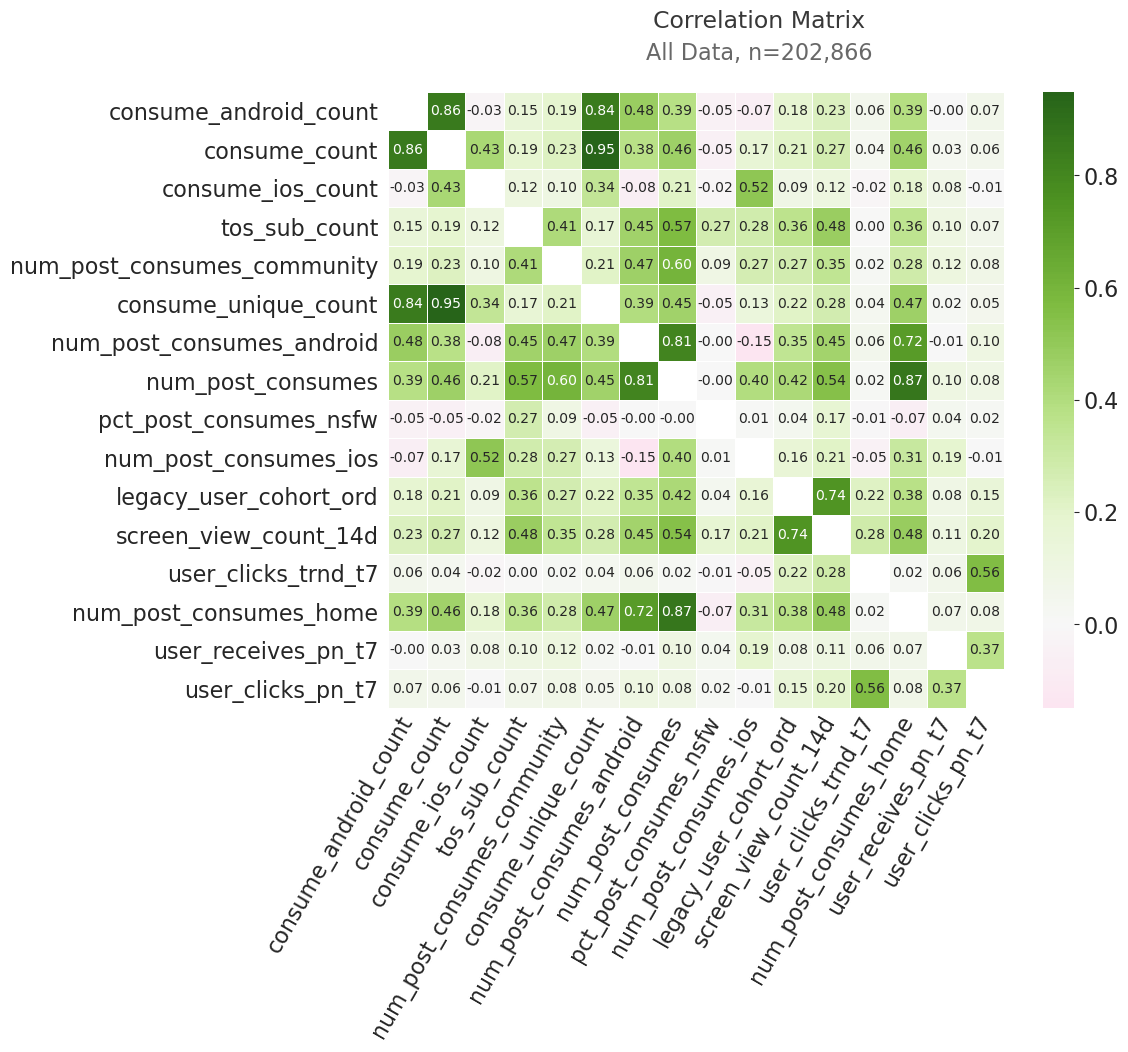

In [125]:
# Use this one that only keeps items below diagonal
#   it's also centered on zero so it's less skewed
plt.figure(figsize=(10, 8))
mask_type = 'diag'  # 'triangle' or 'diag'

l_cols_to_exclude = [
    'num_post_consumes_nsfw',
    'view_and_consume_unique_count',
    'view_count',
    'num_post_consumes_post_detail',
]
print(f"Cols to exclude:\n{l_cols_to_exclude}")
corrmat = (
    X_train[[_ for _ in l_cols_train_ordered if _ not in l_cols_to_exclude]]
    .corr()
)
mask = np.zeros_like(corrmat)
if mask_type == 'triangle':
    # For triangle:
    mask[np.triu_indices_from(mask)] = True
elif mask_type == 'diag':
    # Exclude only the diagonal:
    np.fill_diagonal(mask, 1.0)

with sns.axes_style("white"):
    sns.heatmap(
        corrmat, center=0,
        cmap=cm.PiYG,
        mask=mask,
        annot=True,
        annot_kws={"size": 10},
        square=True,
        fmt="0.2f",
        linewidths=.5,
    )
    plt.yticks(rotation=0)
    plt.xticks(rotation=60, va='center', ha='right', rotation_mode='anchor')

    plt.figtext(
        .5, .96, f"Correlation Matrix",
        fontsize=17, color='#383838', ha='center'
    );
    plt.figtext(
        .5, .92, f"All Data, n={len(X_train):,.0f}",
        fontsize=16, color='#686868', ha='center'
    )
plt.show()

## Importance based on feature permutation
This is EXPENSIVE because we need to shuffle features AND refit a model N times.

In [126]:
from sklearn.inspection import permutation_importance

In [127]:
%%time

perm_importance = permutation_importance(
    d_search_fit['xgboost_pre'].best_estimator_,
    X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

CPU times: user 8.12 s, sys: 7.54 s, total: 15.7 s
Wall time: 13.5 s


In [130]:
# list(d_search_fit['rf'].best_estimator_['preprocess'].transformers_[0][1].get_feature_names())

In [129]:
len(l_train_cols_num)

19

In [138]:
# try to get feature names from pipeline, otherwise from X_train
try:
    ftr_names_ = d_search_fit['xgboost_pre'].best_estimator_['preprocess'].get_feature_names_out()
    # sometimes there are doudlle underscores if we used an encoder like: OneHotEncoder
    ftr_names_ = [
        '__'.join(_.split('__')[1:]) if '__' in _ else _ for _ in ftr_names_
    ]
except KeyError:
    ftr_names_ = list(X_train.columns)
        
df_importances_p = (
    pd.DataFrame(
        {
            'feature_names': ftr_names_,
            'importances': perm_importance.importances_mean,
            'std': perm_importance.importances_std,
        }
    )
    .sort_values(by=['importances'], ascending=False)
)
print(df_importances_p.shape)
df_importances_p.head(20)

(20, 3)


,feature_names,importances,std
3,user_clicks_trnd_t7,0.040797,0.001435
4,screen_view_count_14d,0.011537,0.000223
9,num_post_consumes_ios,0.000613,0.000165
0,tos_sub_count,-0.001437,0.000204
2,user_clicks_pn_t7,-0.003092,0.000539
18,consume_android_count,-0.004602,0.000421
19,legacy_user_cohort_ord,-0.004860,0.000485
10,num_post_consumes_android,-0.009236,0.000423
13,view_and_consume_unique_count,-0.010888,0.000427
8,num_post_consumes_post_detail,-0.013798,0.000806


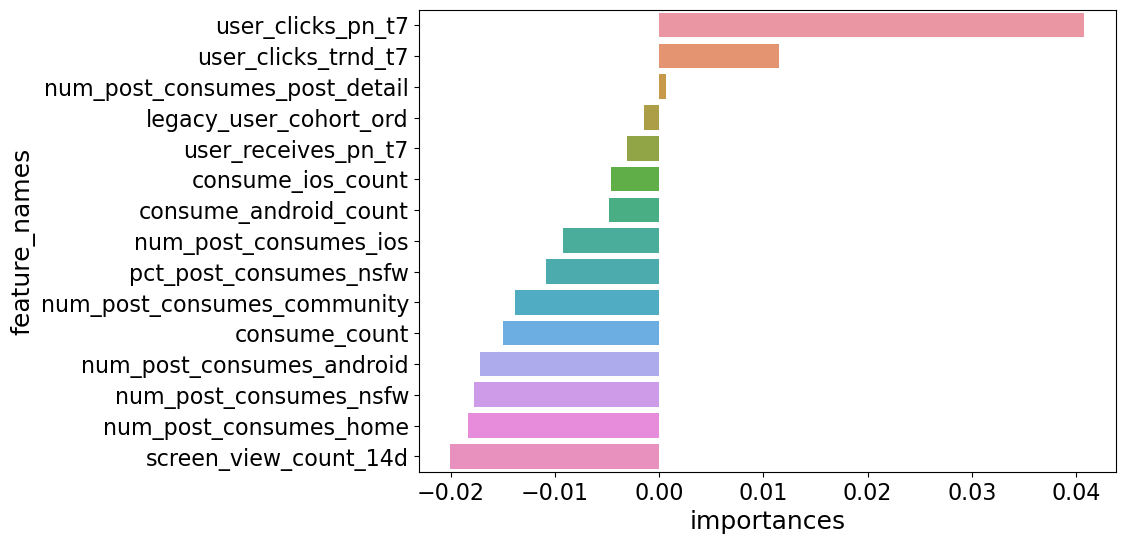

In [133]:
ax = sns.barplot(
    data=df_importances_p.head(15),
    x='importances',
    y='feature_names',
)

<BarContainer object of 15 artists>

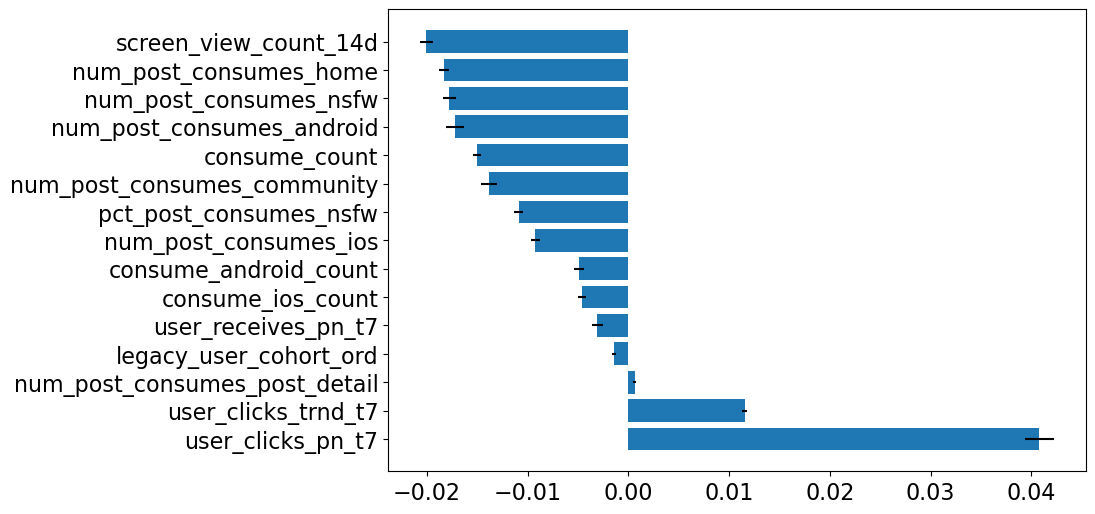

In [134]:

plt.barh(
    y=df_importances_p.head(15)['feature_names'],
    width=df_importances_p.head(15)['importances'],
    xerr=df_importances_p.head(15)['std'],
)

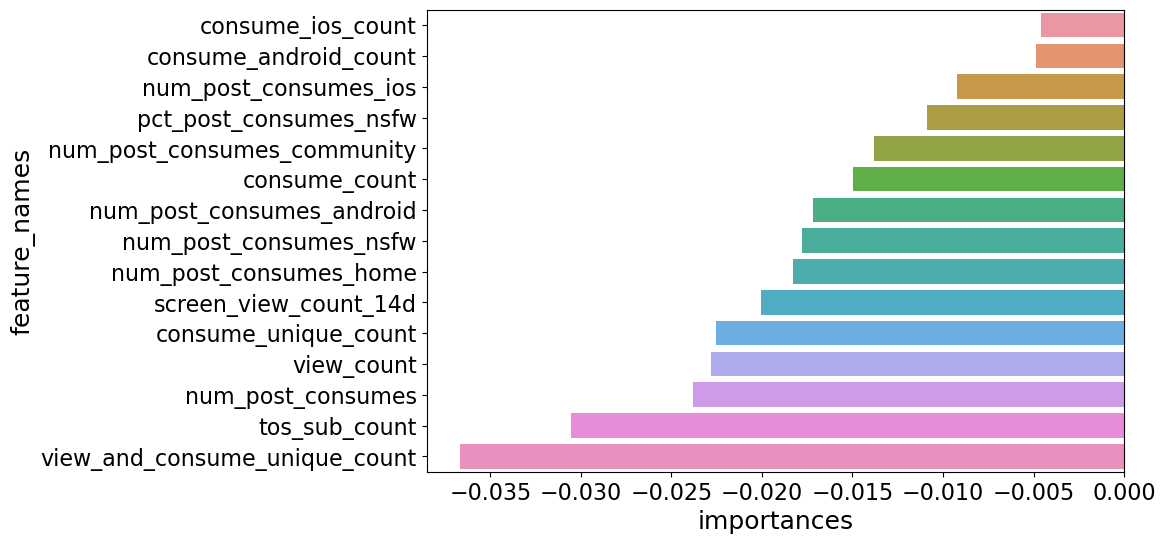

In [135]:
ax = sns.barplot(
    data=df_importances_p.tail(15),
    x='importances',
    y='feature_names',
)

In [136]:
df_importances_p.tail(10)

,feature_names,importances,std
17,consume_count,-0.014987,0.000385
11,num_post_consumes_android,-0.017186,0.000869
12,num_post_consumes_nsfw,-0.017773,0.000664
7,num_post_consumes_home,-0.018304,0.000525
5,screen_view_count_14d,-0.020035,0.000663
15,consume_unique_count,-0.022564,0.000367
16,view_count,-0.022791,0.000347
6,num_post_consumes,-0.023793,0.001326
1,tos_sub_count,-0.030564,0.000686
14,view_and_consume_unique_count,-0.036694,0.000552
